When to run:
- After running the datalog engine and the csv files have been created (CCTX_Withdrawals.csv and CCTX_Deposits.csv)

Functionality:
- Calculates the value in USD transacted in each cross-chain transaction
- Calculates the time difference between transactions in each chain pertaining to the same cross-chain transaction

In [28]:
BRIDGE_NAME = "ronin-bridge"

MAP_SRC_DST_TOKENS = {
    "0xbb0e17ef65f82ab018d8edd776e8dd940327b28b": "0x97a9107c1793bc407d6f527b77e7fff4d812bece",
    "0xcc8fa225d80b9c7d42f96e9570156c65d6caaa25": "0xa8754b9fa15fc18bb59458815510e40a12cd2014",
    "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48": "0x0b7007c13325c48911f73a2dad5fa5dcbf808adc",
    "0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2": "0xc99a6a985ed2cac1ef41640596c5a5f9f4e19ef5"
}

MAP_TOKEN_TO_ID = {
    "0x97a9107c1793bc407d6f527b77e7fff4d812bece": "axie-infinity",
    "0xa8754b9fa15fc18bb59458815510e40a12cd2014": "smooth-love-potion",
    "0x0b7007c13325c48911f73a2dad5fa5dcbf808adc": "usdc",
    "0xc99a6a985ed2cac1ef41640596c5a5f9f4e19ef5": "weth",
}

MAP_TOKEN_TO_DECIMALS = {
    "0x97a9107c1793bc407d6f527b77e7fff4d812bece": 18,
    "0xa8754b9fa15fc18bb59458815510e40a12cd2014": 0,
    "0x0b7007c13325c48911f73a2dad5fa5dcbf808adc": 6,
    "0xc99a6a985ed2cac1ef41640596c5a5f9f4e19ef5": 18,
}

In [2]:
pip install pandas matplotlib python-dotenv requests;


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import pandas as pd

# overwrite the existing file
def create_latex_file(bridge_name):
    with open(f'./{bridge_name}/latex/datalog-results.tex', 'w') as file:
        file.write("")

def format_rule_name(rule_name):
    rule_name = rule_name.replace("_", "")
    rule_name = rule_name.replace("20", "")
    return rule_name

def extractBridgeName(bridge_name):
    bridge = bridge_name.split('-')[0]
    return bridge[0].upper() + bridge[1:]

def add_metrics_to_latex_file(bridge_name, rule, value):
    rule = format_rule_name(rule) + extractBridgeName(bridge_name)

    with open(f'./{bridge_name}/latex/datalog-results.tex', 'a') as file:
        line = "\\newcommand{\\" + rule + "}{" + str(value) + "~}"
        file.write(line + '\n')

create_latex_file(BRIDGE_NAME)

In [5]:
# Add to the data frame the value being transferred in USD, based on the price of the token at that date
def calculateTxValueInUSD(token_address, value, day):

    try:
        token_id = MAP_TOKEN_TO_ID[token_address]
    except Exception:
        return np.nan

    if token_id == "none":
        return np.nan
    
    df_token_price = pd.read_csv(f"../../data/{BRIDGE_NAME}/token_prices/{token_id}_historical_data.csv")

    try:
        price = df_token_price[df_token_price['date'] == day].iloc[0]['price']
        tx_volume = int(value) / (10**(MAP_TOKEN_TO_DECIMALS[token_address])) * price
        return tx_volume
    except KeyError:
        raise KeyError(f"The key '{token_address}' was not present in token the dictionary.")

In [6]:
def addTransactionTimeDifferencesToDataframe(cctxs, time_interval_days):
    # Calculate time differences
    cctxs['time_difference'] = pd.to_numeric(cctxs.iloc[:, 4], errors='coerce') - pd.to_numeric(cctxs.iloc[:, 1], errors='coerce')

    # # Convert Unix timestamps to datetime objects
    # cctxs.iloc[:, 1] = pd.to_numeric(cctxs.iloc[:, 1])
    # cctxs.iloc[:, 4] = pd.to_numeric(cctxs.iloc[:, 4])

    print("NUMBER OF DATAPOINTS:", len(cctxs['time_difference']))
    print("MAX CCTX LATENCY:", max(cctxs['time_difference']))
    print("MIN CCTX LATENCY:", min(cctxs['time_difference']))
    print("AVG CCTX LATENCY:", sum(cctxs['time_difference'])/len(cctxs['time_difference']))
    print("AVG CCTX LATENCY (MINS):", sum(cctxs['time_difference'])/len(cctxs['time_difference'])/60)
    print("AVG CCTX LATENCY (HOURS):", sum(cctxs['time_difference'])/len(cctxs['time_difference'])/60/60)
    print("AVG CCTX LATENCY (DAYS):", sum(cctxs['time_difference'])/len(cctxs['time_difference'])/60/60/24)
    std_dev = cctxs['time_difference'].std()
    print("Standard Deviation of CCTX Latency:", std_dev)

    # Round hour to the nearest multiple of time_interval_days (e.g., 15 represents periods of 15 days)
    cctxs['day_rounded'] = (pd.to_datetime(cctxs.iloc[:, 1], unit='s').dt.day // time_interval_days) * time_interval_days

    # Create a new column combining year, month, day, and rounded hour
    cctxs['datetime_group'] = pd.to_datetime(cctxs.iloc[:, 1], unit='s').dt.strftime('%Y-%m-') + cctxs['day_rounded'].astype(str).str.zfill(2) + " 00:00"

    return cctxs

In [7]:
def plotTimeDifferencesBoxplot(cctxs, logScale, title):
    ax = cctxs.boxplot(column='time_difference', by='datetime_group', grid=True)

    plt.suptitle('')
    plt.xticks(rotation=90)
    ax.set_title(title)
    ax.set_xlabel('Hour of the Day')
    ax.set_ylabel('Time Difference (seconds)')
    if logScale:
        ax.set_yscale('log')
    plt.show()

In [8]:
def plotScatterPlot(cctxs, action):
    plt.figure(figsize=(10, 6))
    plt.scatter(cctxs['time_difference'], cctxs['value_usd'], color='blue', alpha=0.5)
    plt.title(f'Correlation of CCTX Latency and Value Transferred for CCTX {action}')
    plt.xlabel('CCTX Latency (s)')
    plt.ylabel('Value (USD)')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(10**1, 10**8)
    plt.grid(True)

# Analysis on the data of the selected interval

## CCTX Deposits

In [9]:
# Calculate USD value for each cctx

cctxs_deposits = pd.read_csv(F"../datalog/{BRIDGE_NAME}/results/CCTX_Deposit.csv", header=None, sep='\t')
cctxs_deposits["value_usd"] = None

for index, row in cctxs_deposits.iterrows():
    day = datetime.fromtimestamp(row.loc[1]).strftime('%Y-%m-%d')
    tx_volume = calculateTxValueInUSD(row.loc[8], row.loc[11], day)
    cctxs_deposits.at[index, "value_usd"] = tx_volume

In [10]:
print(f"Total Value Deposited in USD: ${cctxs_deposits['value_usd'].sum():.2f}")
print(f"Total Value Deposited in Million USD: ${cctxs_deposits['value_usd'].sum() / 10**6:.2f}M")

Total Value Deposited in USD: $1705944586.55
Total Value Deposited in Million USD: $1705.94M


In [11]:
addTransactionTimeDifferencesToDataframe(cctxs_deposits, 7).head()
cctxs_deposits.rename(columns={0: 'orig_chain_id', 1: 'orig_timestamp', 2: 'orig_tx_hash', 3: 'dst_chain_id', 4: 'dst_timestamp', 5: 'dst_tx_hash', 6: 'deposit_id', 7: 'origin_token', 8: 'dst_token', 9: 'sender', 10: 'beneficiary', 11: 'amount'}, inplace=True)
cctxs_deposits.to_csv(f'./{BRIDGE_NAME}/data/cctxs_deposits.csv', index=False)

NUMBER OF DATAPOINTS: 43971
MAX CCTX LATENCY: 459
MIN CCTX LATENCY: 79
AVG CCTX LATENCY: 191.32059766664392
AVG CCTX LATENCY (MINS): 3.1886766277773986
AVG CCTX LATENCY (HOURS): 0.05314461046295664
AVG CCTX LATENCY (DAYS): 0.00221435876928986
Standard Deviation of CCTX Latency: 45.673680527162226


Correlation between Latency and Value transferred: 0.005329810911876684


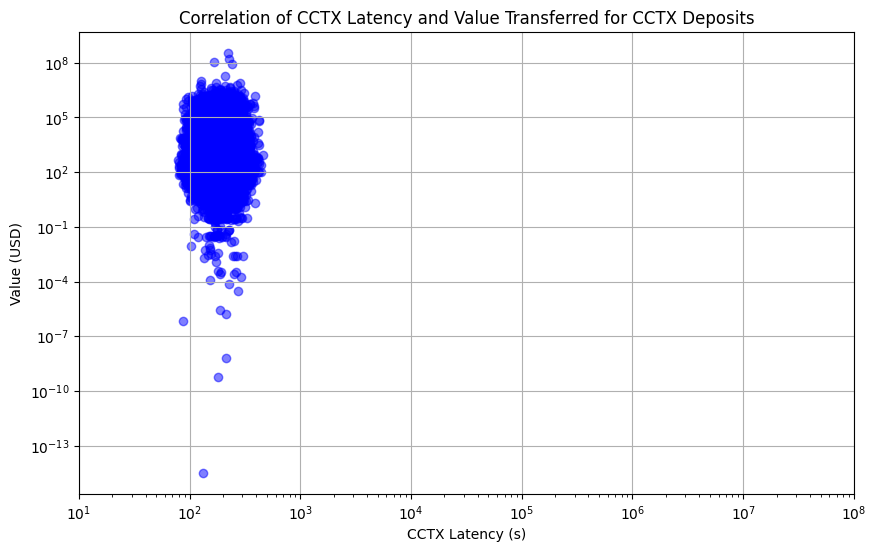

In [12]:
correlation = cctxs_deposits['time_difference'].corr(cctxs_deposits['value_usd'])
print("Correlation between Latency and Value transferred:", correlation)

plotScatterPlot(cctxs_deposits, "Deposits")

NUMBER OF DATAPOINTS: 43700
MAX CCTX LATENCY: 459
MIN CCTX LATENCY: 79
AVG CCTX LATENCY: 191.2487185354691
AVG CCTX LATENCY (MINS): 3.187478642257818
AVG CCTX LATENCY (HOURS): 0.0531246440376303
AVG CCTX LATENCY (DAYS): 0.0022135268349012627
MEDIAN CCTX LATENCY: 187.0
Standard Deviation of CCTX Latency: 45.60636613468294
Total Value Deposited in USD (before attack): $1695255666.35
Total Value Deposited in USD (before attack): $1695.26


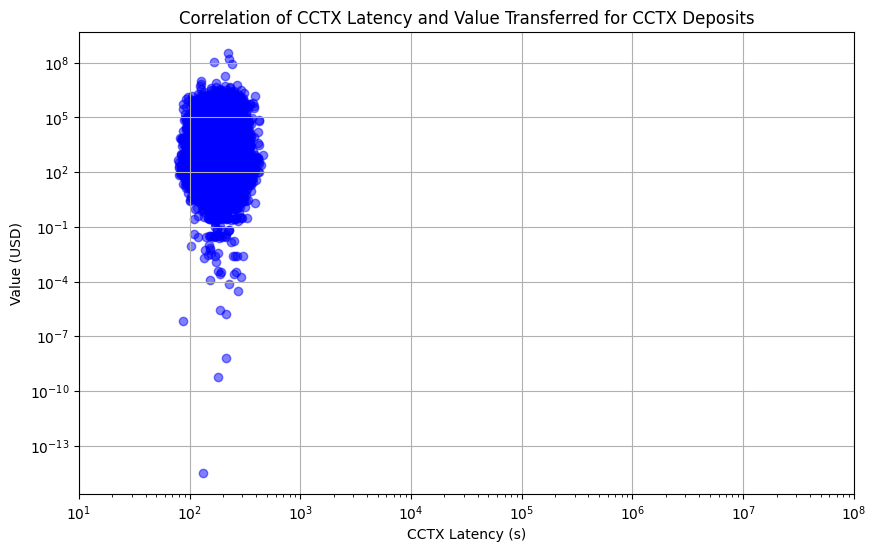

In [13]:
# cctxs_deposits_before_attack contains the CCTXs before the attack on the 2022-03-28
cctxs_deposits_before_attack = cctxs_deposits[cctxs_deposits['dst_timestamp'] < 1648508400]

# calculate size, min, max, mean, median, and standard deviation of the time_difference column
print("NUMBER OF DATAPOINTS:", len(cctxs_deposits_before_attack['time_difference']))
add_metrics_to_latex_file(BRIDGE_NAME, "size_cctx_deposits_latency", len(cctxs_deposits_before_attack['time_difference']))

print("MAX CCTX LATENCY:", max(cctxs_deposits_before_attack['time_difference']))
add_metrics_to_latex_file(BRIDGE_NAME, "max_cctx_deposits_latency", "{:,.2f}".format(max(cctxs_deposits_before_attack['time_difference'])))

print("MIN CCTX LATENCY:", min(cctxs_deposits_before_attack['time_difference']))
add_metrics_to_latex_file(BRIDGE_NAME, "min_cctx_deposits_latency", "{:,.2f}".format(min(cctxs_deposits_before_attack['time_difference'])))

print("AVG CCTX LATENCY:", sum(cctxs_deposits_before_attack['time_difference'])/len(cctxs_deposits_before_attack['time_difference']))
add_metrics_to_latex_file(BRIDGE_NAME, "avg_cctx_deposits_latency", "{:,.2f}".format(sum(cctxs_deposits_before_attack['time_difference'])/len(cctxs_deposits_before_attack['time_difference'])))

print("AVG CCTX LATENCY (MINS):", sum(cctxs_deposits_before_attack['time_difference'])/len(cctxs_deposits_before_attack['time_difference'])/60)
print("AVG CCTX LATENCY (HOURS):", sum(cctxs_deposits_before_attack['time_difference'])/len(cctxs_deposits_before_attack['time_difference'])/60/60)
print("AVG CCTX LATENCY (DAYS):", sum(cctxs_deposits_before_attack['time_difference'])/len(cctxs_deposits_before_attack['time_difference'])/60/60/24)

print("MEDIAN CCTX LATENCY:", cctxs_deposits_before_attack['time_difference'].median())
add_metrics_to_latex_file(BRIDGE_NAME, "median_cctx_deposits_latency", "{:,.2f}".format(cctxs_deposits_before_attack['time_difference'].median()))

std_dev = cctxs_deposits_before_attack['time_difference'].std()
print("Standard Deviation of CCTX Latency:", std_dev)
add_metrics_to_latex_file(BRIDGE_NAME, "std_cctx_deposits_latency", "{:,.2f}".format(std_dev))

total_value = cctxs_deposits_before_attack['value_usd'].sum()
print(f"Total Value Deposited in USD (before attack): ${total_value:.2f}")
print(f"Total Value Deposited in USD (before attack): ${total_value/10**6:.2f}")
add_metrics_to_latex_file(BRIDGE_NAME, "total_value_deposits_before_attack", "{:,.2f}".format(total_value/10**6))

plotScatterPlot(cctxs_deposits_before_attack, "Deposits")

In [22]:
cctxs_deposits_finality_break = pd.read_csv(F"../datalog/{BRIDGE_NAME}/results/CCTX_Deposit_FinalityBreak.csv", header=None, sep='\t')
cctxs_deposits_finality_break["value_usd"] = None

for index, row in cctxs_deposits_finality_break.iterrows():
    day = datetime.fromtimestamp(row.loc[1]).strftime('%Y-%m-%d')
    tx_volume = calculateTxValueInUSD(row.loc[8], row.loc[11], day)
    cctxs_deposits_finality_break.at[index, "value_usd"] = tx_volume

cctxs_deposits_finality_break = addTransactionTimeDifferencesToDataframe(cctxs_deposits_finality_break, 7)

print(f"Total Value Deposited in USD: ${cctxs_deposits_finality_break['value_usd'].sum():.2f}")

# merge cctxs_deposits_finality_break with cctxs_deposits
merged = pd.concat([cctxs_deposits, cctxs_deposits_finality_break])
merged.to_csv(f'./{BRIDGE_NAME}/data/cctxs_deposits-with-finality-break.csv', index=False)

NUMBER OF DATAPOINTS: 15
MAX CCTX LATENCY: 78
MIN CCTX LATENCY: 66
AVG CCTX LATENCY: 73.86666666666666
AVG CCTX LATENCY (MINS): 1.231111111111111
AVG CCTX LATENCY (HOURS): 0.020518518518518516
AVG CCTX LATENCY (DAYS): 0.0008549382716049382
Standard Deviation of CCTX Latency: 4.206570823751586
Total Value Deposited in USD: $489972.42


In [27]:
cctxs_deposits_finality_break.sort_values(by='time_difference', ascending=True)


0           1                                                  2     3  \
3   1  1641118379  0x468868506b014b5729f9926ff8bce17823842747828d...  2020   
2   1  1641107128  0xe9d8e045a474cdea2b9cb1bb0872343bced7bed57abc...  2020   
4   1  1641159218  0xc47a7aecf5d9a26a84a6d8baaf93688770e148c900f1...  2020   
11  1  1644774626  0x5c920585c0f3fec3e1f8f9ff1822b86d01dcfdeb42ba...  2020   
0   1  1641042775  0xb4d5a0b7226608cae9a1e06be795245165f154a94525...  2020   
6   1  1642613232  0xc34828e9b9c4be50d4f913d0f11d927c8f6c5eccb9eb...  2020   
9   1  1643827345  0x967ddac44b2b941cf7ae8763deda9de25eb05aad50a7...  2020   
14  1  1646789993  0x74ebd9eb0a31f113e58bedc5967b26a012f34f2ff4e6...  2020   
5   1  1641349703  0xe33d7066ff4180fd28d94f4fb07dffcc325871c17f3b...  2020   
10  1  1644617346  0xda6bdc5e7944c1e86941874a05670c9671281fc9873e...  2020   
1   1  1641085817  0xaaaba3bc44842ad235097241c371d88026b9ce9e495d...  2020   
7   1  1643439868  0xc31430554e5c7f4f8b32e1fc09809468a3711b514334...  2020   
8   1  1643439868  0xebe1892bde67a88fce77da3eef045ab75598876e47e6...  2020   
12  1  1645437632  0x560a7c556f5d4ab72f77d1df3651ecafcd37750daf6b...  2020   
13  1  1646137502  0xe6488f6a6b9d381543de69f1d79718b35c0ea7818731...  2020   

             4                                                  5        6  \
3   1641118445  0xc2997f0a2e14c7db69cafbc6e58839299d8130a4c331...  1949585   
2   1641107196  0x97119731ad220408d2adae90b91eb123c2a76b53b108...  1949480   
4   1641159288  0x766417f46ee8ac5c38f752361e2fe351b6f99f5750bf...  1949957   
11  1644774696  0xae5f2cc0068c995304ff323dc32c6d4e21c168a17ea5...  1975863   
0   1641042846  0x58c59c51f6a45c053029e5611a528e668aa2941a3226...  1948907   
6   1642613304  0xfe5d02398538cb83222d1284906ec7c78d1f510b67e2...  1960064   
9   1643827417  0xa439de43bc97f4b6535d9310902e146b0557545c4927...  1968472   
14  1646790068  0x731d4707f6642f548fd827b4168f7dc4f93eb1d0ec92...  1985487   
5   1641349780  0x7d69c26991045f7735246d5d4326ccb2e69f2ed6af10...  1951548   
10  1644617423  0xa5779c8688341f901f896a5f4703cffd896080c6414d...  1974640   
1   1641085895  0xc093e6ce589fd99381ef77ea28c3bdcf35ebbf6f392e...  1949278   
7   1643439946  0x438991f6b8ba16f70828477fdb68c154389cc4e1f90f...  1965882   
8   1643439946  0x438991f6b8ba16f70828477fdb68c154389cc4e1f90f...  1965883   
12  1645437710  0x057a69308a885df68489321befbe1239b2df71749430...  1979464   
13  1646137580  0xaab6585b4289d7a01e8f50e5ceed97f30acca2780d75...  1982633   

                                             7  \
3   0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
2   0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
4   0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
11  0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
0   0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
6   0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
9   0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
14  0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
5   0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
10  0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
1   0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
7   0xcc8fa225d80b9c7d42f96e9570156c65d6caaa25   
8   0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
12  0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
13  0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   

                                             8  \
3   0xc99a6a985ed2cac1ef41640596c5a5f9f4e19ef5   
2   0xc99a6a985ed2cac1ef41640596c5a5f9f4e19ef5   
4   0xc99a6a985ed2cac1ef41640596c5a5f9f4e19ef5   
11  0xc99a6a985ed2cac1ef41640596c5a5f9f4e19ef5   
0   0xc99a6a985ed2cac1ef41640596c5a5f9f4e19ef5   
6   0xc99a6a985ed2cac1ef41640596c5a5f9f4e19ef5   
9   0xc99a6a985ed2cac1ef41640596c5a5f9f4e19ef5   
14  0xc99a6a985ed2cac1ef41640596c5a5f9f4e19ef5   
5   0xc99a6a985ed2cac1ef41640596c5a5f9f4e19ef5   
10  0xc99a6a985ed2cac1ef41640596c5a5f9f4e19ef5   
1   0xc99a6a985ed2cac1ef41640596c5a5f9f4e19ef5   
7   0xa8754b9fa15fc18bb59458815510e40a12cd2014   
8   0xc99a6a985ed2cac1ef41640596c5a5f9f4e19ef5   
12  0

Correlation between Latency and Value transferred: 0.0053270941783435015


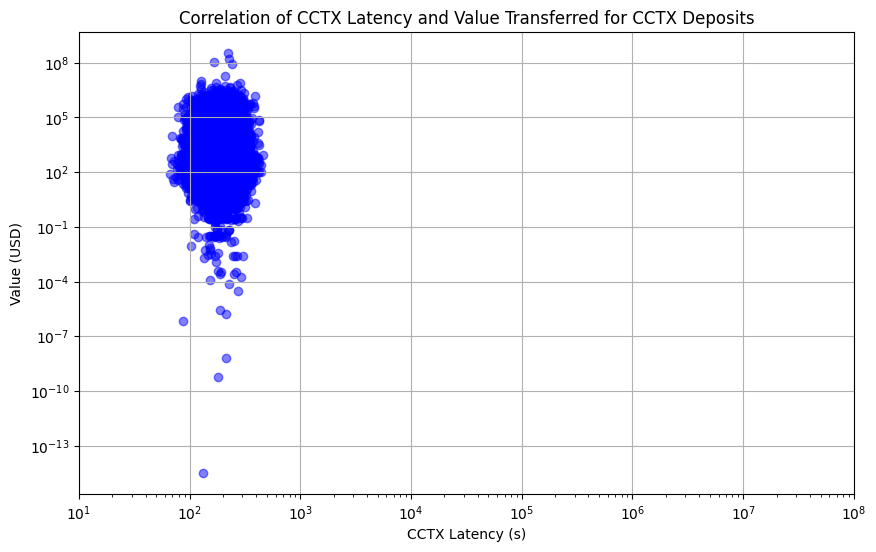

In [15]:
correlation = merged['time_difference'].corr(merged['value_usd'])
print("Correlation between Latency and Value transferred:", correlation)

plotScatterPlot(merged, "Deposits")

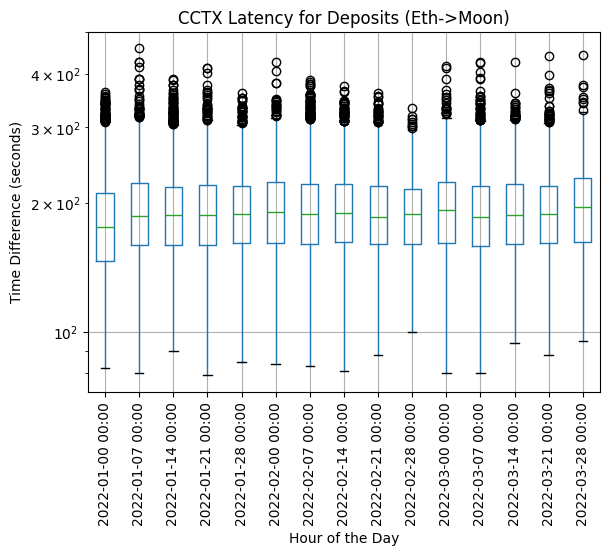

In [18]:
plotTimeDifferencesBoxplot(cctxs_deposits, True, "CCTX Latency for Deposits (Eth->Moon)")

## CCTX Withdrawal

In [16]:
cctxs_withdrawal = pd.read_csv(F"../datalog/{BRIDGE_NAME}/results/CCTX_Withdrawal.csv", header=None, sep='\t')
cctxs_withdrawal["value_usd"] = None

for index, row in cctxs_withdrawal.iterrows():
    day = datetime.fromtimestamp(row.loc[1]).strftime('%Y-%m-%d')
    tx_volume = calculateTxValueInUSD(row.loc[7], row.loc[11], day)
    cctxs_withdrawal.at[index, "value_usd"] = tx_volume

In [17]:
print(f"Total Value Withdrawn in USD: ${cctxs_withdrawal['value_usd'].sum():.2f}")
print(f"Total Value Withdrawn in Million USD: ${cctxs_withdrawal['value_usd'].sum() / 10**6:.2f}M")

Total Value Withdrawn in USD: $2055641825.38
Total Value Withdrawn in Million USD: $2055.64M


In [18]:
addTransactionTimeDifferencesToDataframe(cctxs_withdrawal, 7).head()
cctxs_withdrawal.rename(columns={0: 'orig_chain_id', 1: 'orig_timestamp', 2: 'orig_tx_hash', 3: 'dst_chain_id', 4: 'dst_timestamp', 5: 'dst_tx_hash', 6: 'withdrawal_id', 7: 'origin_token', 8: 'dst_token', 9: 'sender', 10: 'beneficiary', 11: 'amount'}, inplace=True)
cctxs_withdrawal.to_csv(f'./{BRIDGE_NAME}/data/cctxs_withdrawals.csv', index=False)

NUMBER OF DATAPOINTS: 22828
MAX CCTX LATENCY: 7346416
MIN CCTX LATENCY: 46
AVG CCTX LATENCY: 159742.41768880322
AVG CCTX LATENCY (MINS): 2662.3736281467204
AVG CCTX LATENCY (HOURS): 44.37289380244534
AVG CCTX LATENCY (DAYS): 1.8488705751018892
Standard Deviation of CCTX Latency: 662414.4423522046


Correlation between Latency and Value transferred: -0.006120244183138648


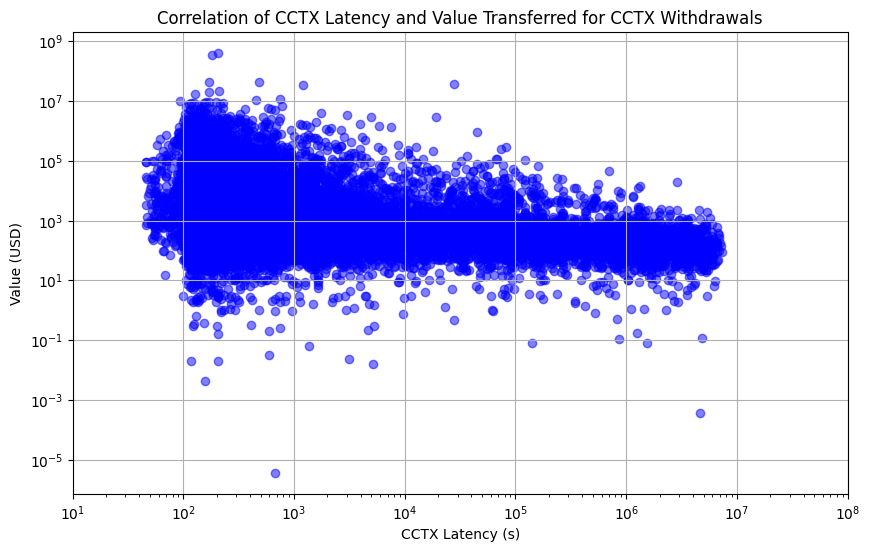

In [19]:
correlation = cctxs_withdrawal['time_difference'].corr(cctxs_withdrawal['value_usd'])
print("Correlation between Latency and Value transferred:", correlation)

plotScatterPlot(cctxs_withdrawal, "Withdrawals")

In [20]:
cctxs_withdrawals_finality_break = pd.read_csv(F"../datalog/{BRIDGE_NAME}/results/CCTX_Withdrawal_FinalityBreak.csv", header=None, sep='\t')
cctxs_withdrawals_finality_break["value_usd"] = None

for index, row in cctxs_withdrawals_finality_break.iterrows():
    day = datetime.fromtimestamp(row.loc[1]).strftime('%Y-%m-%d')
    tx_volume = calculateTxValueInUSD(row.loc[7], row.loc[11], day)
    cctxs_withdrawals_finality_break.at[index, "value_usd"] = tx_volume

cctxs_withdrawals_finality_break = addTransactionTimeDifferencesToDataframe(cctxs_withdrawals_finality_break, 7)

print(f"Total Value Withdrawn in USD: ${cctxs_withdrawals_finality_break['value_usd'].sum():.2f}")
# merge cctxs_withdrawals_finality_break with cctxs_withdrawal
merged = pd.concat([cctxs_withdrawal, cctxs_withdrawals_finality_break])
merged.to_csv(f'./{BRIDGE_NAME}/data/cctxs_withdrawals-with-finality-break.csv', index=False)

NUMBER OF DATAPOINTS: 24
MAX CCTX LATENCY: 45
MIN CCTX LATENCY: 11
AVG CCTX LATENCY: 37.625
AVG CCTX LATENCY (MINS): 0.6270833333333333
AVG CCTX LATENCY (HOURS): 0.010451388888888889
AVG CCTX LATENCY (DAYS): 0.000435474537037037
Standard Deviation of CCTX Latency: 7.32958566952843
Total Value Withdrawn in USD: $177026.46


NUMBER OF DATAPOINTS: 22629
MAX CCTX LATENCY: 7346416
MIN CCTX LATENCY: 46
AVG CCTX LATENCY: 159555.38083874673
AVG CCTX LATENCY (MINS): 2659.2563473124455
AVG CCTX LATENCY (HOURS): 44.32093912187409
AVG CCTX LATENCY (DAYS): 1.8467057967447538
MEDIAN CCTX LATENCY: 330.0
Standard Deviation of CCTX Latency: 660045.1278980214
Total Value Withdrawn in USD (before attack): $2044902923.64
Total Value Withdrawn in USD (before attack): $2044.90


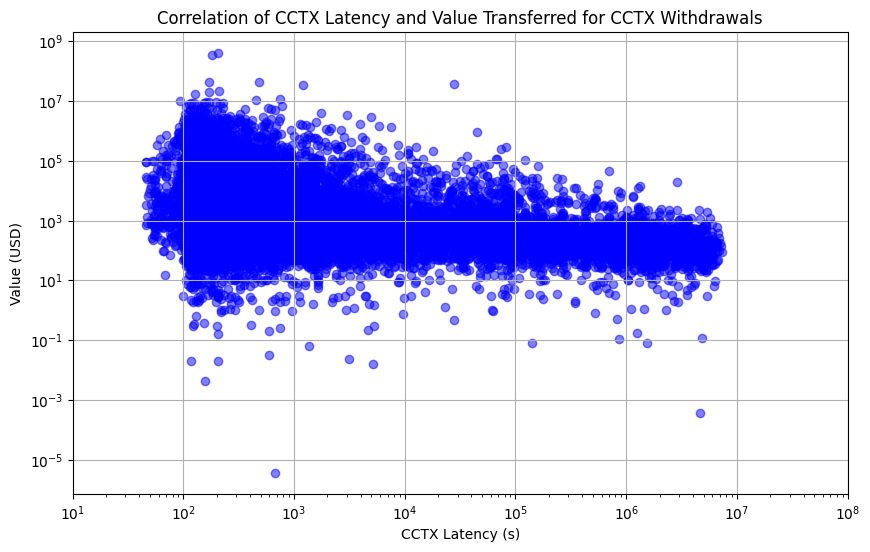

In [21]:
# cctxs_withdrawals_before_attack contains the CCTXs before the attack on the 2022-03-28
cctxs_withdrawals_before_attack = cctxs_withdrawal[cctxs_withdrawal['dst_timestamp'] < 1648508400]

# calculate size, min, max, mean, median, and standard deviation of the time_difference column
print("NUMBER OF DATAPOINTS:", len(cctxs_withdrawals_before_attack['time_difference']))
add_metrics_to_latex_file(BRIDGE_NAME, "size_cctx_withdrawals_latency", len(cctxs_withdrawals_before_attack['time_difference']))

print("MAX CCTX LATENCY:", max(cctxs_withdrawals_before_attack['time_difference']))
add_metrics_to_latex_file(BRIDGE_NAME, "max_cctx_withdrawals_latency",  "{:,.2f}".format(max(cctxs_withdrawals_before_attack['time_difference'])))

print("MIN CCTX LATENCY:", min(cctxs_withdrawals_before_attack['time_difference']))
add_metrics_to_latex_file(BRIDGE_NAME, "min_cctx_withdrawals_latency",  "{:,.2f}".format(min(cctxs_withdrawals_before_attack['time_difference'])))

print("AVG CCTX LATENCY:", sum(cctxs_withdrawals_before_attack['time_difference'])/len(cctxs_withdrawals_before_attack['time_difference']))
add_metrics_to_latex_file(BRIDGE_NAME, "avg_cctx_withdrawals_latency", "{:,.2f}".format(sum(cctxs_withdrawals_before_attack['time_difference'])/len(cctxs_withdrawals_before_attack['time_difference'])))

print("AVG CCTX LATENCY (MINS):", sum(cctxs_withdrawals_before_attack['time_difference'])/len(cctxs_withdrawals_before_attack['time_difference'])/60)
print("AVG CCTX LATENCY (HOURS):", sum(cctxs_withdrawals_before_attack['time_difference'])/len(cctxs_withdrawals_before_attack['time_difference'])/60/60)
print("AVG CCTX LATENCY (DAYS):", sum(cctxs_withdrawals_before_attack['time_difference'])/len(cctxs_withdrawals_before_attack['time_difference'])/60/60/24)

print("MEDIAN CCTX LATENCY:", cctxs_withdrawals_before_attack['time_difference'].median())
add_metrics_to_latex_file(BRIDGE_NAME, "median_cctx_withdrawals_latency", "{:,.2f}".format(cctxs_withdrawals_before_attack['time_difference'].median()))

std_dev = cctxs_withdrawals_before_attack['time_difference'].std()
print("Standard Deviation of CCTX Latency:", std_dev)

add_metrics_to_latex_file(BRIDGE_NAME, "std_cctx_withdrawals_latency", "{:,.2f}".format(std_dev))


total_value = cctxs_withdrawals_before_attack['value_usd'].sum()
print(f"Total Value Withdrawn in USD (before attack): ${total_value:.2f}")
print(f"Total Value Withdrawn in USD (before attack): ${total_value/10**6:.2f}")
add_metrics_to_latex_file(BRIDGE_NAME, "total_value_withdrawals_before_attack", "{:,.2f}".format(total_value/10**6))

plotScatterPlot(cctxs_withdrawals_before_attack, "Withdrawals")

**Notes to add in the paper:**
The amount of time it takes for transactions to complete does not seem to affect the transaction value in a linear way -- i.e., higher value transactions do not necessarily take longer time to process.
Actually, the plot shows that the whole range of transferred values swipe the entire plot across all possible latencies of cross-chain transactions.

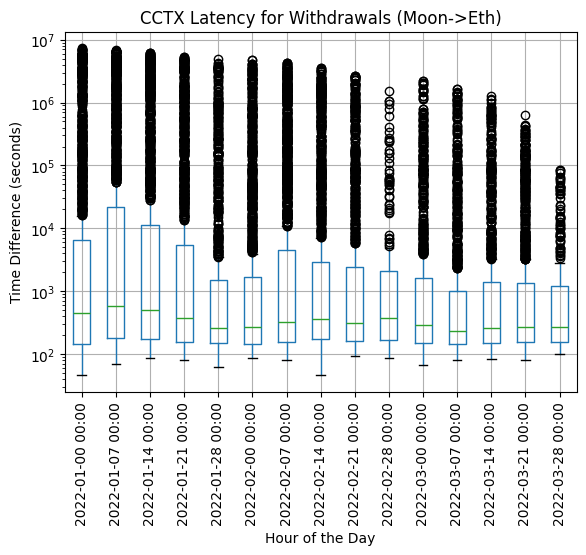

In [26]:
plotTimeDifferencesBoxplot(cctxs_withdrawal, True, "CCTX Latency for Withdrawals (Moon->Eth)")

This variability in the latency of cctxs from Ronin->Ethereum is explained by:
- the users need to perform the final transfer to Ethereum such that the bridge operator does not have to pay for the gas fees
- some users to not have funds in their address in Ethereum, therefore delay the final withdrawal on Ethereum

# MERGE DATAFRAMES

In [27]:
# Add a source column to each DataFrame
cctxs_deposits.rename(columns={"deposit_id": "action_id"}, inplace=True)
cctxs_withdrawal.rename(columns={"withdrawal_id": "action_id"}, inplace=True)

cctxs_deposits['action'] = 'deposit'
cctxs_withdrawal['action'] = 'withdrawal'


combined_cctxs = pd.concat([cctxs_deposits, cctxs_withdrawal])
combined_cctxs.to_csv(f'./{BRIDGE_NAME}/data/combined_cctxs.csv', index=False)

### Unmatched SC_ValidERC20TokenDeposited

In [28]:
deposited = pd.read_csv(F"../datalog/{BRIDGE_NAME}/results/SC_DepositsWithoutMatch.csv", header=None, sep='\t')
deposited["value_usd"] = None

deposited["date"] = pd.to_datetime(deposited.iloc[:, 1], unit='s').dt.strftime('%Y-%m-%d %H:%M')

for index, row in deposited.iterrows():
    day = datetime.fromtimestamp(row.loc[1]).strftime('%Y-%m-%d')
    tx_volume = calculateTxValueInUSD(row.loc[6], row.loc[9], day)
    deposited.at[index, "value_usd"] = tx_volume

print(len(deposited))
deposited.head()

15


0           1                                                  2     3  \
0  1  1641042775  0xb4d5a0b7226608cae9a1e06be795245165f154a94525...  2020   
1  1  1641085817  0xaaaba3bc44842ad235097241c371d88026b9ce9e495d...  2020   
2  1  1641107128  0xe9d8e045a474cdea2b9cb1bb0872343bced7bed57abc...  2020   
3  1  1641118379  0x468868506b014b5729f9926ff8bce17823842747828d...  2020   
4  1  1641159218  0xc47a7aecf5d9a26a84a6d8baaf93688770e148c900f1...  2020   

         4                                           5  \
0  1948907  0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
1  1949278  0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
2  1949480  0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
3  1949585  0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
4  1949957  0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   

                                            6  \
0  0xc99a6a985ed2cac1ef41640596c5a5f9f4e19ef5   
1  0xc99a6a985ed2cac1ef41640596c5a5f9f4e19ef5   
2  0xc99a6a985ed2cac1ef41640596c5a5f9f4e19ef5   
3  0xc99a6a985ed2cac1ef41640596c5a5f9f4e19ef5   
4  0xc99a6a985ed2cac1ef41640596c5a5f9f4e19ef5   

                                            7  \
0  0x0f30345ca29c2d0310e5485dc99815a9691f0c73   
1  0xe641dca2e131fa8bfe1d7931b9b040e3fe0c5bdc   
2  0xd1bf90758eee44ba981d92faf8ac4accba5f0a5a   
3  0x4c170dc3201b87356f7d10aa6848246cc1739a90   
4  0xa083c6b0ece22611d5328ec7f854340155defab2   

                                            8                     9  \
0  0x67a9f6b200b4c93732252275aa518d2ec322b848     11000000000000000   
1  0x87253131b37a329a55fa6b181db4b487019087e1  30000000000000000000   
2  0x1e28d08b485297a87241307ebbbb19537482b5b1    160000000000000000   
3  0xbc3f676d19eb11b9e3096475f415f043c37f5102     21000000000000000   
4  0x24312961a2c88047b7434df3bfbd9be699b4280f     73000000000000000   

      value_usd              date  
0     42.131108  2022-01-01 13:12  
1  112851.08652  2022-01-02 01:10  
2    601.872461  2022-01-02 07:05  
3     78.995761  2022-01-02 10:12  
4    274.604311  2022-01-02 21:33

### Unmatched TC_ValidERC20TokenDeposited

In [29]:
deposited = pd.read_csv(F"../datalog/{BRIDGE_NAME}/results/TC_DepositsWithoutMatch.csv", header=None, sep='\t')
deposited["value_usd"] = None

deposited["date"] = pd.to_datetime(deposited.iloc[:, 1], unit='s').dt.strftime('%Y-%m-%d %H:%M')

for index, row in deposited.iterrows():
    day = datetime.fromtimestamp(row.loc[1]).strftime('%Y-%m-%d')
    try:
        tx_volume = calculateTxValueInUSD(row.loc[4], row.loc[6], day)
        deposited.at[index, "value_usd"] = tx_volume
    except Exception as e:
        tx_volume = np.nan

print(len(deposited))
deposited.head()

19


0           1                                                  2  \
0  2020  1640995217  0x87397e0b44c361958e3f011615c52425e6b6136dc5eb...   
1  2020  1641042846  0x58c59c51f6a45c053029e5611a528e668aa2941a3226...   
2  2020  1641085895  0xc093e6ce589fd99381ef77ea28c3bdcf35ebbf6f392e...   
3  2020  1641107196  0x97119731ad220408d2adae90b91eb123c2a76b53b108...   
4  2020  1641118445  0xc2997f0a2e14c7db69cafbc6e58839299d8130a4c331...   

         3                                           4  \
0  1948477  0x97a9107c1793bc407d6f527b77e7fff4d812bece   
1  1948907  0xc99a6a985ed2cac1ef41640596c5a5f9f4e19ef5   
2  1949278  0xc99a6a985ed2cac1ef41640596c5a5f9f4e19ef5   
3  1949480  0xc99a6a985ed2cac1ef41640596c5a5f9f4e19ef5   
4  1949585  0xc99a6a985ed2cac1ef41640596c5a5f9f4e19ef5   

                                            5                      6  \
0  0xb54415f4486d72977d650f8bd68559ead72e9a96  500678032290000000000   
1  0x67a9f6b200b4c93732252275aa518d2ec322b848      11000000000000000   
2  0x87253131b37a329a55fa6b181db4b487019087e1   30000000000000000000   
3  0x1e28d08b485297a87241307ebbbb19537482b5b1     160000000000000000   
4  0xbc3f676d19eb11b9e3096475f415f043c37f5102      21000000000000000   

      value_usd              date  
0  48320.974419  2022-01-01 00:00  
1     42.131108  2022-01-01 13:14  
2  112851.08652  2022-01-02 01:11  
3    601.872461  2022-01-02 07:06  
4     78.995761  2022-01-02 10:14

There are 4 remaining from the 15 that do not respect the finality times

2020	1640995217	0x87397e0b44c361958e3f011615c52425e6b6136dc5eb29657f368f7386a3ba90	1948477	0x97a9107c1793bc407d6f527b77e7fff4d812bece	0xb54415f4486d72977d650f8bd68559ead72e9a96	500678032290000000000
2020	1645107104	0x14341c15696a1196cb258a037c82ae982bae359c0beaff04f98671d1ca2fc948	1977779	0x173a2d4fa585a63acd02c107d57f932be0a71bcc	0xab43bbb09b2e1b120d5b7dad4cdd6b2b74be215f	5
2020	1645107659	0xfbf96951e6d27dffdb29e708cf9132b2386fa8baca37d7892bf1259c9c9b6301	1977781	0x173a2d4fa585a63acd02c107d57f932be0a71bcc	0x949ef390fb4281da171797668527cd05864b7415	15
2020	1646660999	0x7abad9a1bd6f3622c9ace284847ac9b28deabbdec20f04d45f481391dca15f82	1985001	0x173a2d4fa585a63acd02c107d57f932be0a71bcc	0x949ef390fb4281da171797668527cd05864b7415	20

The first one is mapped in the additional_sc_token_deposited.facts. It was a transfer made in the beginning of the selected interval.
The last three are transfers of AEC (Axie Egg Coin), which is not mapped.

### Unmatched TC_ValidNativeTokenWithdrawal and TC_ValidERC20TokenWithdrawal

In [93]:
withdrawals = pd.read_csv(F"../datalog/{BRIDGE_NAME}/results/TC_WithdrawalsWithoutMatch.csv", header=None, sep='\t')
withdrawals["value_usd"] = None

withdrawals["date"] = pd.to_datetime(withdrawals.iloc[:, 1], unit='s').dt.strftime('%Y-%m-%d %H:%M')

for index, row in withdrawals.iterrows():
    day = datetime.fromtimestamp(row.loc[1]).strftime('%Y-%m-%d')
    tx_volume = calculateTxValueInUSD(row.loc[4], row.loc[8], day)
    withdrawals.at[index, "value_usd"] = tx_volume

print(len(withdrawals))
withdrawals.head()

12583


0           1                                                  2  \
0  2020  1640996672  0x687ea833a7b418ca294690c3868eb0817560e20541bb...   
1  2020  1640996696  0x61b06c4e7b0aa91b559338e2e5519473a9efe251c079...   
2  2020  1640997956  0x410a1251566e0c7c6101f7dabe900ad4990a48dd1c8e...   
3  2020  1640998040  0xee9a8483418077f3916cc550de4fa62e114bb8c2fea7...   
4  2020  1640998388  0x7093c81c4776d4196b166b4c1809622d0dce66c53e31...   

         3                                           4  \
0  1029093  0xa8754b9fa15fc18bb59458815510e40a12cd2014   
1  1029094  0x97a9107c1793bc407d6f527b77e7fff4d812bece   
2  1029097  0xc99a6a985ed2cac1ef41640596c5a5f9f4e19ef5   
3  1029098  0xc99a6a985ed2cac1ef41640596c5a5f9f4e19ef5   
4  1029099  0xa8754b9fa15fc18bb59458815510e40a12cd2014   

                                            5  \
0  0xcc8fa225d80b9c7d42f96e9570156c65d6caaa25   
1  0xbb0e17ef65f82ab018d8edd776e8dd940327b28b   
2  0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
3  0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
4  0xcc8fa225d80b9c7d42f96e9570156c65d6caaa25   

                                            6  \
0  0xfa06ad7160af3b136fdb1db403d5e1e99d7826b2   
1  0x00537c301e61688315125e938a3995c1a2c72c07   
2  0x0f989a09b462c0ed9827226f277ba3eeb6f3cf1f   
3  0x2b93806e4b538566027d62b273ddf8c16b94fd8b   
4  0xdf0633bbe3bb7958d6bf353936faa2359b8e3894   

                                            7                    8  value_usd  \
0  0xd6426dc639a8c9fbec91b70bff2bc121ab6ffdf5                  132   3.607713   
1  0xdb5135b32846c5167033619f5be7a5bc44fa927a  1033495445694568561  99.743755   
2  0x0f989a09b462c0ed9827226f277ba3eeb6f3cf1f    71222799804999095   272.7905   
3  0xc3093cebf2d274bd2f5c296eb8418e6872a36d9d     9664297361111111  37.015233   
4  0x88bcda8aaa774602af51d058cf8541286e97debe                   10   0.273312   

               date  
0  2022-01-01 00:24  
1  2022-01-01 00:24  
2  2022-01-01 00:45  
3  2022-01-01 00:47  
4  2022-01-01 00:53

We retrieved additional data on Ethereum after the selected interval, which caused 767 withdrawals to be matched. But there are still transactions not matched...

In [94]:
withdrawals = pd.read_csv(F"../datalog/{BRIDGE_NAME}/results/TC_WithdrawalsWithoutMatchWithAdditionalData.csv", header=None, sep='\t')
withdrawals["value_usd"] = None

withdrawals["date"] = pd.to_datetime(withdrawals.iloc[:, 1], unit='s').dt.strftime('%Y-%m-%d %H:%M')

withdrawals_finality_break = pd.read_csv(F"../datalog/{BRIDGE_NAME}/results/CCTX_Withdrawal_FinalityBreak.csv", header=None, sep='\t')

withdrawals = withdrawals[~withdrawals[3].isin(withdrawals_finality_break[6])]

for index, row in withdrawals.iterrows():
    day = datetime.fromtimestamp(row.loc[1]).strftime('%Y-%m-%d')
    tx_volume = calculateTxValueInUSD(row.loc[4], row.loc[8], day)
    withdrawals.at[index, "value_usd"] = tx_volume

print(len(withdrawals))
withdrawals.head()

11794


0           1                                                  2  \
0  2020  1640996672  0x687ea833a7b418ca294690c3868eb0817560e20541bb...   
1  2020  1640996696  0x61b06c4e7b0aa91b559338e2e5519473a9efe251c079...   
2  2020  1640998040  0xee9a8483418077f3916cc550de4fa62e114bb8c2fea7...   
3  2020  1640998388  0x7093c81c4776d4196b166b4c1809622d0dce66c53e31...   
4  2020  1640998874  0x532913580143407c2ef2ea1435c1add6cfd7d2983baa...   

         3                                           4  \
0  1029093  0xa8754b9fa15fc18bb59458815510e40a12cd2014   
1  1029094  0x97a9107c1793bc407d6f527b77e7fff4d812bece   
2  1029098  0xc99a6a985ed2cac1ef41640596c5a5f9f4e19ef5   
3  1029099  0xa8754b9fa15fc18bb59458815510e40a12cd2014   
4  1029103  0xc99a6a985ed2cac1ef41640596c5a5f9f4e19ef5   

                                            5  \
0  0xcc8fa225d80b9c7d42f96e9570156c65d6caaa25   
1  0xbb0e17ef65f82ab018d8edd776e8dd940327b28b   
2  0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
3  0xcc8fa225d80b9c7d42f96e9570156c65d6caaa25   
4  0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   

                                            6  \
0  0xfa06ad7160af3b136fdb1db403d5e1e99d7826b2   
1  0x00537c301e61688315125e938a3995c1a2c72c07   
2  0x2b93806e4b538566027d62b273ddf8c16b94fd8b   
3  0xdf0633bbe3bb7958d6bf353936faa2359b8e3894   
4  0xc937a48fd91e0d831196aa01db34ab05047c9fd8   

                                            7                    8  \
0  0xd6426dc639a8c9fbec91b70bff2bc121ab6ffdf5                  132   
1  0xdb5135b32846c5167033619f5be7a5bc44fa927a  1033495445694568561   
2  0xc3093cebf2d274bd2f5c296eb8418e6872a36d9d     9664297361111111   
3  0x88bcda8aaa774602af51d058cf8541286e97debe                   10   
4  0x9031b6ea9bb3ca3a7fac51cd8ebb73e0ead72e9a    44668698897118352   

    value_usd              date  
0    3.607713  2022-01-01 00:24  
1   99.743755  2022-01-01 00:24  
2   37.015233  2022-01-01 00:47  
3    0.273312  2022-01-01 00:53  
4  171.085618  2022-01-01 01:01

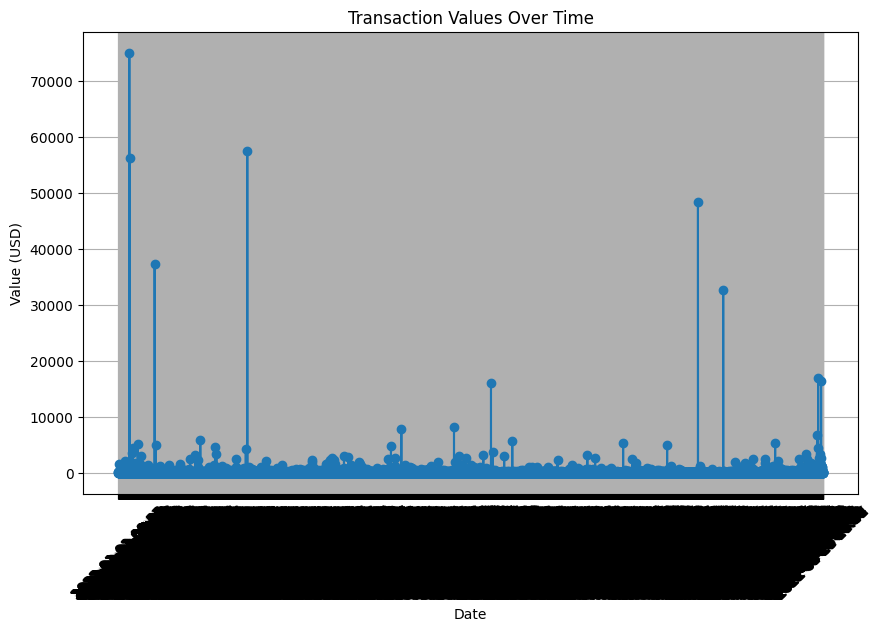

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(withdrawals['date'], withdrawals['value_usd'], marker='o')
plt.xlabel('Date')
plt.ylabel('Value (USD)')
plt.title('Transaction Values Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## Some analysis on this data:

Users try to withdraw tokens but since the destination address does not have any funds to cover gas fees, there is no match on Ethereum.

This problem is not verified on the other end (ethereum -> moonbeam) because the transaction is always issued by the same address 0x776a9097e01de7e7aa2ddd92989f27c8b5c3ae68!!!

We need to get data on the addresses to which the withdrawals are being done. The main question is whether they had enough funds to cover transaction fees.

In [96]:
def create_df_with_ethereum_addresses_involved_in_unmatched_withdrawal(df):
    # Lets only store the date of tx and the destination address
    selected_columns_by_name = df[['date', 'value_usd']]

    selected_col2_by_index = df.iloc[:, 1].rename('timestamp')
    selected_col3_by_index = df.iloc[:, 2].rename('tx_hash')
    selected_col8_by_index = df.iloc[:, 7].rename('dst_address')

    dst_ethereum_addresses = pd.concat([selected_columns_by_name, selected_col2_by_index, selected_col3_by_index, selected_col8_by_index], axis=1)
    
    # Display the new DataFrame
    return dst_ethereum_addresses

In [97]:
dst_ethereum_addresses = create_df_with_ethereum_addresses_involved_in_unmatched_withdrawal(withdrawals)
print(len(dst_ethereum_addresses))
dst_ethereum_addresses.head()

11794


date   value_usd   timestamp  \
0  2022-01-01 00:24    3.607713  1640996672   
1  2022-01-01 00:24   99.743755  1640996696   
2  2022-01-01 00:47   37.015233  1640998040   
3  2022-01-01 00:53    0.273312  1640998388   
4  2022-01-01 01:01  171.085618  1640998874   

                                             tx_hash  \
0  0x687ea833a7b418ca294690c3868eb0817560e20541bb...   
1  0x61b06c4e7b0aa91b559338e2e5519473a9efe251c079...   
2  0xee9a8483418077f3916cc550de4fa62e114bb8c2fea7...   
3  0x7093c81c4776d4196b166b4c1809622d0dce66c53e31...   
4  0x532913580143407c2ef2ea1435c1add6cfd7d2983baa...   

                                  dst_address  
0  0xd6426dc639a8c9fbec91b70bff2bc121ab6ffdf5  
1  0xdb5135b32846c5167033619f5be7a5bc44fa927a  
2  0xc3093cebf2d274bd2f5c296eb8418e6872a36d9d  
3  0x88bcda8aaa774602af51d058cf8541286e97debe  
4  0x9031b6ea9bb3ca3a7fac51cd8ebb73e0ead72e9a

In [98]:
from dotenv import load_dotenv
import requests
import json
import os

load_dotenv()

def get_api_key():
    return os.getenv('BLOCKDAEMON_API_KEY')

RPC_URL = f'https://svc.blockdaemon.com/ethereum/mainnet/native'  # Replace 'KEY' with your actual API key
REQ_HEADERS = {
    'Content-Type': 'application/json',
    'Accept': 'application/json',
    'X-API-Key': get_api_key()
}
REQ_DATA = {
    "id": 1,
    "jsonrpc": "2.0",
    "params": [],
    "method": "eth_getBalance"
}

blocks_df = pd.read_csv(f"../../data/{BRIDGE_NAME}/blocks/ethereum.csv")
blocks_df['timestamp'] = blocks_df['timestamp'].astype(int)

In [99]:
# We are going to retrieve the balance of each user on Ethereum, at the time the transaction on Moonbeam was issued, to see if the address had enough funds to cover for gas fees
# Therefore, we find the block number on Ethereum nearest to a certain timestamp and use the eth_getBalance RPC method
def find_closest_block(target_timestamp):
    blocks_df['time_diff'] = (blocks_df['timestamp'] - target_timestamp).abs()
    
    closest_index = blocks_df['time_diff'].idxmin()
    
    return blocks_df.loc[closest_index, 'block_number']

def fill_dst_ethereum_addresses_balances():
    length = len(dst_ethereum_addresses)

    for index, row in dst_ethereum_addresses.iterrows():
        if index < 4753:
            continue
        dst_address = row['dst_address']
        block_number = find_closest_block(row['timestamp'])

        REQ_DATA['params'] = [dst_address, hex(block_number)]
        response = requests.post(RPC_URL, headers=REQ_HEADERS, data=json.dumps(REQ_DATA))

        REQ_DATA['params'] = [dst_address, hex(20190684)] # this is the last finalized block (ethereum) at the date of writing this script
        response2 = requests.post(RPC_URL, headers=REQ_HEADERS, data=json.dumps(REQ_DATA))

        if response.status_code == 200:
            balance = str(int(response.json()["result"], 16))
            balance2 = str(int(response2.json()["result"], 16))
            print(f"{index+1}/{length} Address {dst_address} had balance {balance} in block no {block_number}; current balance: {balance2}")
            dst_ethereum_addresses.at[index, 'balance_at_date'] = balance
            dst_ethereum_addresses.at[index, 'balance_today'] = balance2

        else:
            with open("./errors.txt", "a") as error_file:
                error_file.write(f"Transaction failed: {dst_address}\n")

In [52]:
fill_dst_ethereum_addresses_balances()

4754/11816 Address 0x2ad0fd88f5dfa9612a857ebe17c5da15b6e12c0b had balance 7938760476629376 in block no 14091419; current balance: 214923279097548658
4755/11816 Address 0x6e86b3c6092fca8f07c547e27404e44c6943cfdc had balance 0 in block no 14091481; current balance: 0
4756/11816 Address 0x1f5302b8572e540269c5862c99a2a8f2aee6e80d had balance 62660104000000000 in block no 14091579; current balance: 1466611170184000
4757/11816 Address 0xf855324c60792542936b6883591855fa66c35809 had balance 155466754787150201729 in block no 14091648; current balance: 20844190998049624858
4758/11816 Address 0x649df86813059b1d228554b1f2b45bf9b027176e had balance 0 in block no 14091700; current balance: 0
4759/11816 Address 0x3e57b0136fa5da4ce68d517c979fb9f1c611bb48 had balance 22592878771558992 in block no 14091744; current balance: 38137287462628271
4760/11816 Address 0x69f4d22b86097bcafadc489a80f4b3908cc914e2 had balance 0 in block no 14091744; current balance: 0
4761/11816 Address 0x88e47a61f4e6abfeddacbb98f9

In [53]:
dst_ethereum_addresses.to_csv(f"./{BRIDGE_NAME}/data/dst_ethereum_addresses.csv", index=False)

In [100]:
dst_ethereum_addresses = pd.read_csv(f"./{BRIDGE_NAME}/data/dst_ethereum_addresses.csv")

# Create new dst_ethereum_addresses with aggregated data -- balance_at_date, balance_today with the count of each aggregated by 100 bins

dst_ethereum_addresses['balance_at_date'] = pd.to_numeric(dst_ethereum_addresses['balance_at_date'], errors='coerce')
dst_ethereum_addresses['balance_today'] = pd.to_numeric(dst_ethereum_addresses['balance_today'], errors='coerce')

dst_ethereum_addresses['balance_at_date_ether'] = dst_ethereum_addresses['balance_at_date'] / 10**18
dst_ethereum_addresses['balance_today_ether'] = dst_ethereum_addresses['balance_today'] / 10**18

add_metrics_to_latex_file(BRIDGE_NAME, "total_dst_addresses_in_withdrawals_with_no_match", len(dst_ethereum_addresses))
dst_ethereum_addresses.to_csv(f"./{BRIDGE_NAME}/data/dst_ethereum_addresses_with_ether.csv", index=False)

In [101]:
dst_ethereum_addresses

date   value_usd   timestamp  \
0      2022-01-01 00:24    3.607713  1640996672   
1      2022-01-01 00:24   99.743755  1640996696   
2      2022-01-01 00:47   37.015233  1640998040   
3      2022-01-01 00:53    0.273312  1640998388   
4      2022-01-01 01:01  171.085618  1640998874   
...                 ...         ...         ...   
11789  2022-03-29 19:02   79.278664  1648580578   
11790  2022-03-29 21:06   32.113125  1648588012   
11791  2022-03-30 09:47   32.774475  1648633629   
11792  2022-04-02 18:42   73.166482  1648924921   
11793  2022-04-03 10:41   63.843903  1648982462   

                                                 tx_hash  \
0      0x687ea833a7b418ca294690c3868eb0817560e20541bb...   
1      0x61b06c4e7b0aa91b559338e2e5519473a9efe251c079...   
2      0xee9a8483418077f3916cc550de4fa62e114bb8c2fea7...   
3      0x7093c81c4776d4196b166b4c1809622d0dce66c53e31...   
4      0x532913580143407c2ef2ea1435c1add6cfd7d2983baa...   
...                                                  ...   
11789  0x08ff5303e21d09525ee17b67e18130cc3ddd465cf852...   
11790  0xdbdcbf06d485e61bf2e804e9ad6fc7f51798844d2e0f...   
11791  0xa7ec7fe5de6088e1a1656adbdd3fe4348a5561be66f6...   
11792  0x5c8a669bf7da17b0916620bc914789c76b36257fa134...   
11793  0x67cfec821bdd9978f00636b7a717ccd3400cfaeb9dec...   

                                      dst_address  \
0      0xd6426dc639a8c9fbec91b70bff2bc121ab6ffdf5   
1      0xdb5135b32846c5167033619f5be7a5bc44fa927a   
2      0xc3093cebf2d274bd2f5c296eb8418e6872a36d9d   
3      0x88bcda8aaa774602af51d058cf8541286e97debe   
4      0x9031b6ea9bb3ca3a7fac51cd8ebb73e0ead72e9a   
...                                           ...   
11789  0x10967cc1a80cb84ecd0e4d09299cbcd5410a4cf6   
11790  0x5fe215c6dec71e2c440a49d1d871214978e9e95b   
11791  0x4a8aa7fb60cbb371c45ee78dbb744899e45bdef6   
11792  0x55a5a97120c29ea184db06bf7b4cb4dae66d7107   
11793  0x550f72b33d44977a783d61d7a411cf8ebe24b77a   

       dst_address_balance_at_date  dst_address_balance_today  \
0                                0                          0   
1                                0                          0   
2                                0                          0   
3                                0                          0   
4                                0                          0   
...                            ...                        ...   
11789                            0                          0   
11790                            0                          0   
11791                            0                          0   
11792                            0                          0   
11793                            0                          0   

       balance_at_date  balance_today  balance_at_date_ether  \
0         0.000000e+00   0.000000e+00               0.000000   
1         7.295878e+15   1.286758e+14               0.007296   
2         1.358140e+16   1.365125e+16               0.013581   
3         4.913961e+14   1.229882e+14               0.000491   
4         1.439644e+15   1.439644e+15               0.001440   
...                ...            ...                    ...   
11789     2.952764e+15   4.698221e+16               0.002953   
11790     9.797650e+15   6.151358e+14               0.009798   
11791     0.000000e+00   9.385901e+14               0.000000   
11792     7.473468e+15   5.789765e+15               0.007473   
11793     5.387257e+15   2.276995e+14               0.005387   

       balance_today_ether  
0                 0.000000  
1                 0.000129  
2                 0.013651  
3                 0.000123  
4                 0.001440  
...                    ...  
11789             0.046982  
11790             0.000615  
11791             0.000939  
11792             0.005790  
11793             0.000228  

[11794 rows x 11 columns]

In [102]:
size = len(dst_ethereum_addresses[dst_ethereum_addresses['balance_at_date'] == 0])
print(f"Txs in which the destination had 0 balance on Ethereum: {size}")
add_metrics_to_latex_file(BRIDGE_NAME, "total_dst_addresses_in_withdrawals_with_no_match_no_balance", size)

size2 = len(dst_ethereum_addresses[dst_ethereum_addresses['balance_at_date'].map(int) < 1100000000000000])
print(f"Txs in which the destination did not have funds to pay for tx fee on Ethereum: {size2}")
add_metrics_to_latex_file(BRIDGE_NAME, "total_dst_addresses_in_withdrawals_with_no_match_under_fee", size2)

Txs in which the destination had 0 balance on Ethereum: 6054
Txs in which the destination did not have funds to pay for tx fee on Ethereum: 7469


In [103]:
size = len(dst_ethereum_addresses[(dst_ethereum_addresses['balance_at_date'] == 0) & (dst_ethereum_addresses['balance_today'] == 0)])
print(f"Addresses that still today do not have funds on Ethereum: {size}")
add_metrics_to_latex_file(BRIDGE_NAME, "total_dst_addresses_in_withdrawals_with_no_match_no_balance_and_under_fee", size)

Addresses that still today do not have funds on Ethereum: 5261


In [104]:
value = dst_ethereum_addresses['value_usd'].sum()
print(f"Total Value Not Withdrawn in USD: ${value:.2f}")
print(f"Total Value Not Withdrawn in Million USD: ${value / 10**6:.2f}M")
add_metrics_to_latex_file(BRIDGE_NAME, "total_dst_addresses_in_withdrawals_with_no_match_total_value", "{:,.2f}M".format(value / 10**6))

Total Value Not Withdrawn in USD: $1184090.52
Total Value Not Withdrawn in Million USD: $1.18M


In [105]:
sorted_dst_ethereum_addresses = dst_ethereum_addresses.sort_values('value_usd', ascending=False)

print("MAX:", max(dst_ethereum_addresses['value_usd']))
print("MIN:", min(dst_ethereum_addresses['value_usd']))
print("AVG:", sum(dst_ethereum_addresses['value_usd'])/len(dst_ethereum_addresses['value_usd']))
print("MEDIAN:", sorted_dst_ethereum_addresses['value_usd'].median())

sorted_dst_ethereum_addresses.head(10)

MAX: 57613.44837346922
MIN: 0.0
AVG: 100.39770434110146
MEDIAN: 25.1861385535


date     value_usd   timestamp  \
2167   2022-01-12 17:18  57613.448373  1642007932   
9724   2022-03-06 11:01  48477.290932  1646564516   
596    2022-01-04 05:03  37251.525476  1641272614   
10130  2022-03-11 20:43  32618.228465  1647031387   
11680  2022-03-29 16:08  16897.031798  1648570118   
11750  2022-03-29 17:23  16410.285409  1648574618   
6265   2022-02-07 14:28  15954.793189  1644244082   
5648   2022-02-03 08:25   8174.284448  1643876753   
4760   2022-01-28 07:19   7878.353783  1643354342   
11664  2022-03-29 15:47   6770.525912  1648568822   

                                                 tx_hash  \
2167   0xc445011da5f7ddeec43ceb4d235fb281ea9ca1b61bbd...   
9724   0x6ee2656a0530882323bb922990239c7bb125b1908744...   
596    0x97dbd59809022b0c3e85ecb430a21365896969036904...   
10130  0xa89788527b33eca22ea0d22f5cc7627832d2653bd5c5...   
11680  0x2f3c8de03deadb744b230e799297720c66bd8ce078c2...   
11750  0x280886710f3e52193575979f44cfca37e4fb5471f298...   
6265   0xb015edc4d072b2b12144681f325857117e36bc0384cf...   
5648   0xcd2ee21624eef8e829448a36ad8382956f6206e6b8ad...   
4760   0xe716488e4507d7593be671ec5245bea307e05eba02d6...   
11664  0xe73ed8fe2d82b12fe2bb3417bd3ace757ec1ec7502a4...   

                                      dst_address  \
2167   0xeffdc093dfa1b8f008e3d6982e12ed30e1e7bf03   
9724   0x7653c9364bb800e1136aa0634c4629ebe76a744e   
596    0x2a149dc9a2d3517029209572c60f1c1c434656a2   
10130  0xd61dc52f029857f5a744ca4334703b2a323a1adc   
11680  0xfacef700458d4fc9746f7f3e0d37b462711ff09e   
11750  0xf7b18e107eb36797f4ce36de756630b9c30969ad   
6265   0xf6e7a49f408c1ad6e94d2251280aa13fd8ade519   
5648   0xba5edc0d2ae493c9574328d77dc36eef19f699e2   
4760   0x34eb5c0a3a08eeb18141a626da5ab7366791ce43   
11664  0xca436e14855323927d6e6264470ded36455fc8bd   

       dst_address_balance_at_date  dst_address_balance_today  \
2167                             0                          0   
9724                             0                          0   
596                              0                          0   
10130                            0                          0   
11680                            0                          0   
11750                            0                          0   
6265                             0                          0   
5648                             0                          0   
4760                             0                          0   
11664                            0                          0   

       balance_at_date  balance_today  balance_at_date_ether  \
2167      1.000001e+17   0.000000e+00               0.100000   
9724      3.841878e+17   1.201103e+19               0.384188   
596       9.996019e+18   1.100321e+20               9.996019   
10130     1.553349e+18   3.038248e+16               1.553349   
11680     1.991648e+18   4.972749e+17               1.991648   
11750     2.031912e+17   1.900993e+16               0.203191   
6265      6.836983e+18   9.743874e+16               6.836983   
5648      2.113779e+18   1.636285e+16               2.113779   
4760      2.248120e+19   1.790972e+18              22.481197   
11664     1.339656e+19   4.072209e+13              13.396557   

       balance_today_ether  
2167              0.000000  
9724             12.011035  
596             110.032115  
10130             0.030382  
11680             0.497275  
11750             0.019010  
6265              0.097439  
5648              0.016363  
4760              1.790972  
11664             0.000041

In [106]:
count_per_dst_address = dst_ethereum_addresses['dst_address'].value_counts()
multiple_counts = len(count_per_dst_address[count_per_dst_address > 1])
single_counts = len(count_per_dst_address[count_per_dst_address == 1])
print("Number of addresses that tried withdrawing exactly once:", single_counts)
add_metrics_to_latex_file(BRIDGE_NAME, "total_dst_addresses_in_withdrawals_with_no_match_single_tries", single_counts)
print("Number of addresses that tried withdrawing more than once:", multiple_counts)
add_metrics_to_latex_file(BRIDGE_NAME, "total_dst_addresses_in_withdrawals_with_no_match_multiple_tries", multiple_counts)

Number of addresses that tried withdrawing exactly once: 9657
Number of addresses that tried withdrawing more than once: 956


In [107]:
# add a column to the df which says if they have multiple counts or not
dst_ethereum_addresses['multiple_counts'] = dst_ethereum_addresses['dst_address'].map(lambda address: count_per_dst_address[address] > 1)
# count number of unique addresses that have multiple counts
multiple_counts = len(dst_ethereum_addresses[dst_ethereum_addresses['multiple_counts']])
print(multiple_counts)

# print correlation between value_usd and multiple_counts
correlation = dst_ethereum_addresses['multiple_counts'].corr(dst_ethereum_addresses['value_usd'])
print("Correlation between multiple counts and value transferred:", correlation)
add_metrics_to_latex_file(BRIDGE_NAME, "total_dst_addresses_in_withdrawals_with_no_match_correlation_USD_with_multiple_counts", "{:,.3f}".format(correlation))

2137
Correlation between multiple counts and value transferred: -0.01469391496566279


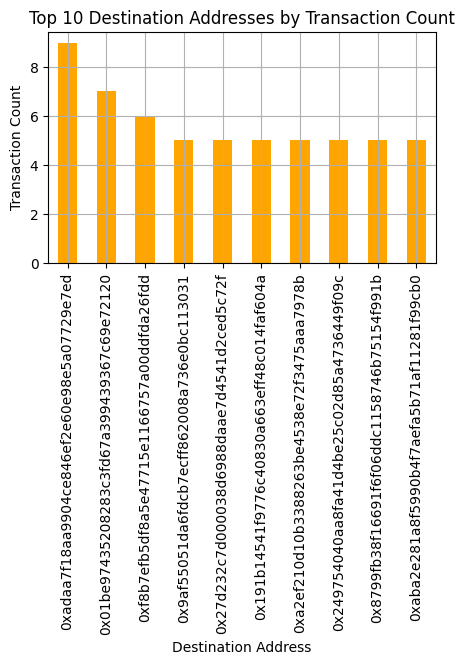

In [62]:
top_dst_addresses = sorted_dst_ethereum_addresses['dst_address'].value_counts().head(10)

# Bar plot
plt.figure(figsize=(5, 3))
top_dst_addresses.plot(kind='bar', color='orange')
plt.title('Top 10 Destination Addresses by Transaction Count')
plt.xlabel('Destination Address')
plt.ylabel('Transaction Count')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

There was one address that interacted with the bridge 5 times to withdraw funds but they were never withdrawn. These were made exactly at the time the bridge was hacked but not successful. Over the next hours, multiple transactions were issued to withdraw funds but none was successful because the contract on Ethereum was meanwhile paused.

This also shows the consequence of an attack, people wanting to withdraw funds from one blockchain to another to avoid using protocols.

In [108]:
before_attack_dst_ethereum_addresses = dst_ethereum_addresses[dst_ethereum_addresses['timestamp'] < 1648508400]
print(len(before_attack_dst_ethereum_addresses))
add_metrics_to_latex_file(BRIDGE_NAME, "total_dst_addresses_in_withdrawals_with_no_match_before", len(before_attack_dst_ethereum_addresses))

size = len(before_attack_dst_ethereum_addresses[before_attack_dst_ethereum_addresses['balance_at_date'] == 0])
print(f"Addresses that did not have funds on Ethereum: {size}")
add_metrics_to_latex_file(BRIDGE_NAME, "total_dst_addresses_in_withdrawals_with_no_match_before_no_balance", size)

size2 = len(before_attack_dst_ethereum_addresses[before_attack_dst_ethereum_addresses['balance_at_date'].map(int) < 1100000000000000])
print(f"Txs in which the destination did not have funds to pay for tx fee on Ethereum: {size2}")
add_metrics_to_latex_file(BRIDGE_NAME, "total_dst_addresses_in_withdrawals_with_no_match_before_under_fee", size2)

size = len(before_attack_dst_ethereum_addresses[(before_attack_dst_ethereum_addresses['balance_at_date'] == 0) & (before_attack_dst_ethereum_addresses['balance_today'] == 0)])
print(f"Addresses that still today do not have funds on Ethereum: {size}")
add_metrics_to_latex_file(BRIDGE_NAME, "total_dst_addresses_in_withdrawals_with_no_match_before_no_balance_and_under_fee", size)

value = before_attack_dst_ethereum_addresses['value_usd'].sum()
print(f"Total Value not Withdrawn in USD: ${value:.2f}")
print(f"Total Value not Withdrawn in Thousands USD: ${value / 10**6:.2f}M")
add_metrics_to_latex_file(BRIDGE_NAME, "total_dst_addresses_in_withdrawals_with_no_match_before_total_value", "{:,.2f}M".format(value / 10**6))

11574
Addresses that did not have funds on Ethereum: 5988
Txs in which the destination did not have funds to pay for tx fee on Ethereum: 7381
Addresses that still today do not have funds on Ethereum: 5212
Total Value not Withdrawn in USD: $1093442.06
Total Value not Withdrawn in Thousands USD: $1.09M


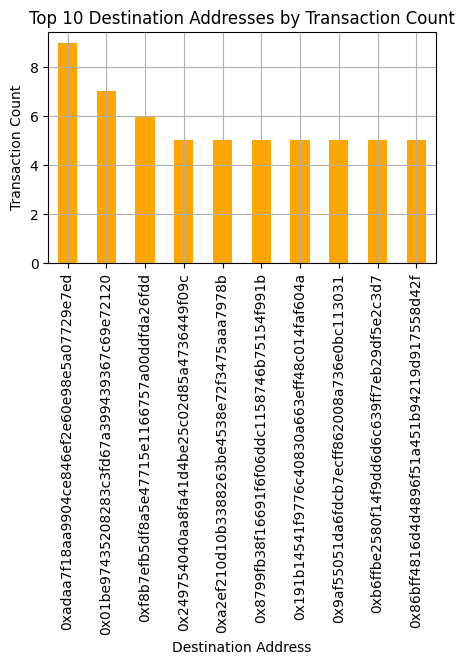

In [65]:
top_dst_addresses = before_attack_dst_ethereum_addresses['dst_address'].value_counts().head(10)

# Bar plot
plt.figure(figsize=(5, 3))
top_dst_addresses.plot(kind='bar', color='orange')
plt.title('Top 10 Destination Addresses by Transaction Count')
plt.xlabel('Destination Address')
plt.ylabel('Transaction Count')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

In [109]:
unique = len(before_attack_dst_ethereum_addresses['dst_address'].unique())
print(unique)

count_per_dst_address = before_attack_dst_ethereum_addresses['dst_address'].value_counts()
multiple_counts = len(count_per_dst_address[count_per_dst_address > 1])
single_counts = len(count_per_dst_address[count_per_dst_address == 1])
print("Number of addresses that tried withdrawing more than once:", multiple_counts)
add_metrics_to_latex_file(BRIDGE_NAME, "total_dst_addresses_in_withdrawals_with_no_match_before_single_tries", single_counts)

print("Number of addresses that tried withdrawing exactly once:", single_counts)
add_metrics_to_latex_file(BRIDGE_NAME, "total_dst_addresses_in_withdrawals_with_no_match_before_multiple_tries", multiple_counts)

10422
Number of addresses that tried withdrawing more than once: 932
Number of addresses that tried withdrawing exactly once: 9490


In [110]:
after_attack_dst_ethereum_addresses = dst_ethereum_addresses[dst_ethereum_addresses['timestamp'] >= 1648508400]
print(len(after_attack_dst_ethereum_addresses))
add_metrics_to_latex_file(BRIDGE_NAME, "total_dst_addresses_in_withdrawals_with_no_match_after", len(after_attack_dst_ethereum_addresses))

size = len(after_attack_dst_ethereum_addresses[after_attack_dst_ethereum_addresses['balance_at_date'] == 0])
print(f"Addresses that did not have funds on Ethereum: {size}")
add_metrics_to_latex_file(BRIDGE_NAME, "total_dst_addresses_in_withdrawals_with_no_match_after_no_balance", size)

size2 = len(after_attack_dst_ethereum_addresses[after_attack_dst_ethereum_addresses['balance_at_date'].map(int) < 1100000000000000])
print(f"Txs in which the destination did not have funds to pay for tx fee on Ethereum: {size2}")
add_metrics_to_latex_file(BRIDGE_NAME, "total_dst_addresses_in_withdrawals_with_no_match_after_under_fee", size2)

size = len(after_attack_dst_ethereum_addresses[(after_attack_dst_ethereum_addresses['balance_at_date'] == 0) & (after_attack_dst_ethereum_addresses['balance_today'] == 0)])
print(f"Addresses that still today do not have funds on Ethereum: {size}")
add_metrics_to_latex_file(BRIDGE_NAME, "total_dst_addresses_in_withdrawals_with_no_match_after_no_balance_and_under_fee", size)

value = after_attack_dst_ethereum_addresses['value_usd'].sum()
print(f"Total Value not Withdrawn in USD: ${value:.2f}")
print(f"Total Value not Withdrawn in Million USD: ${value / 10**6:.2f}M")
add_metrics_to_latex_file(BRIDGE_NAME, "total_dst_addresses_in_withdrawals_with_no_match_after_total_value", "{:,.2f}M".format(value / 10**6))

220
Addresses that did not have funds on Ethereum: 66
Txs in which the destination did not have funds to pay for tx fee on Ethereum: 88
Addresses that still today do not have funds on Ethereum: 49
Total Value not Withdrawn in USD: $90648.47
Total Value not Withdrawn in Million USD: $0.09M


In [111]:
unique = len(after_attack_dst_ethereum_addresses['dst_address'].unique())
print(unique)

count_per_dst_address = after_attack_dst_ethereum_addresses['dst_address'].value_counts()
multiple_counts = len(count_per_dst_address[count_per_dst_address > 1])
single_counts = len(count_per_dst_address[count_per_dst_address == 1])
print("Number of addresses that tried withdrawing exactly once:", single_counts)
add_metrics_to_latex_file(BRIDGE_NAME, "total_dst_addresses_in_withdrawals_with_no_match_after_single_tries", single_counts)

print("Number of addresses that tried withdrawing more than once:", multiple_counts)
add_metrics_to_latex_file(BRIDGE_NAME, "total_dst_addresses_in_withdrawals_with_no_match_after_multiple_tries", multiple_counts)

197
Number of addresses that tried withdrawing exactly once: 176
Number of addresses that tried withdrawing more than once: 21


A provocative question... is a hack good or bad for bridges? They take users funds... If the hack is small enough it may compensate the value...

### Plot the difference between the withdrawal cross-chain transactions and the ones issued to the TC and not merged with any tx on the SC

This is a violation of a cross-chain rule, but not stealing funds from the bridge. Users are sending funds to the bridge and never withdrawing...

In [29]:
unmatched_cctxs_withdrawals = pd.read_csv(F"../datalog/{BRIDGE_NAME}/results/TC_WithdrawalsWithoutMatch.csv", header=None, sep='\t')
unmatched_cctxs_withdrawals["value_usd"] = None

unmatched_cctxs_withdrawals["date"] = pd.to_datetime(unmatched_cctxs_withdrawals.iloc[:, 1], unit='s').dt.strftime('%Y-%m-%d %H:%M')

for index, row in unmatched_cctxs_withdrawals.iterrows():
    day = datetime.fromtimestamp(row.loc[1]).strftime('%Y-%m-%d')
    tx_volume = calculateTxValueInUSD(row.loc[4], row.loc[8], day)
    unmatched_cctxs_withdrawals.at[index, "value_usd"] = tx_volume


matched_cctxs_withdrawals = pd.read_csv(F"../datalog/{BRIDGE_NAME}/results/CCTX_Withdrawal.csv", header=None, sep='\t')
matched_cctxs_withdrawals["value_usd"] = None

matched_cctxs_withdrawals["date"] = pd.to_datetime(matched_cctxs_withdrawals.iloc[:, 1], unit='s').dt.strftime('%Y-%m-%d %H:%M')

for index, row in matched_cctxs_withdrawals.iterrows():
    day = datetime.fromtimestamp(row.loc[1]).strftime('%Y-%m-%d')
    tx_volume = calculateTxValueInUSD(row.loc[7], row.loc[11], day)
    matched_cctxs_withdrawals.at[index, "value_usd"] = tx_volume


# Convert the 'date' column to datetime
unmatched_cctxs_withdrawals['date'] = pd.to_datetime(unmatched_cctxs_withdrawals['date'])
unmatched_cctxs_withdrawals.set_index('date', inplace=True)

matched_cctxs_withdrawals['date'] = pd.to_datetime(matched_cctxs_withdrawals['date'])
matched_cctxs_withdrawals.set_index('date', inplace=True)

In [32]:
unmatched_cctxs_withdrawals_after_attack = unmatched_cctxs_withdrawals[unmatched_cctxs_withdrawals.index >= '2022-03-28']

print("Number of Txs After Attack: ", len(unmatched_cctxs_withdrawals_after_attack))
print("Total Value Withdrawn in USD: ${:.2f}".format(unmatched_cctxs_withdrawals_after_attack['value_usd'].sum()))

Number of Txs After Attack:  468
Total Value Withdrawn in USD: $24770442.80


In [33]:
unmatched_cctxs_withdrawals_before_attack = unmatched_cctxs_withdrawals[unmatched_cctxs_withdrawals.index < '2022-03-28']

print("Number of Txs Before Attack: ", len(unmatched_cctxs_withdrawals_before_attack))
print("Total Value Withdrawn in USD: ${:.2f}".format(unmatched_cctxs_withdrawals_before_attack['value_usd'].sum()))

Number of Txs Before Attack:  12113
Total Value Withdrawn in USD: $1380242.53


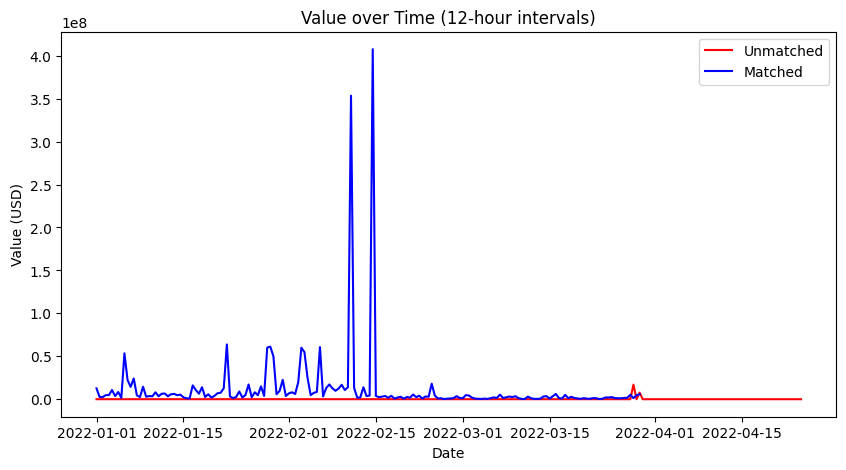

In [71]:
# Resample the data to 12-hour intervals and aggregate using the mean
unmatched_cctxs_withdrawals_resampled = unmatched_cctxs_withdrawals.resample('12h').sum()
matched_cctxs_withdrawals_resampled = matched_cctxs_withdrawals.resample('12h').sum()

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(unmatched_cctxs_withdrawals_resampled.index, unmatched_cctxs_withdrawals_resampled["value_usd"], label='Unmatched', color='red')
plt.plot(matched_cctxs_withdrawals_resampled.index, matched_cctxs_withdrawals_resampled["value_usd"], label='Matched', color='blue')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Value (USD)')
plt.title('Value over Time (12-hour intervals)')
plt.legend()


# Display the plot
plt.show()

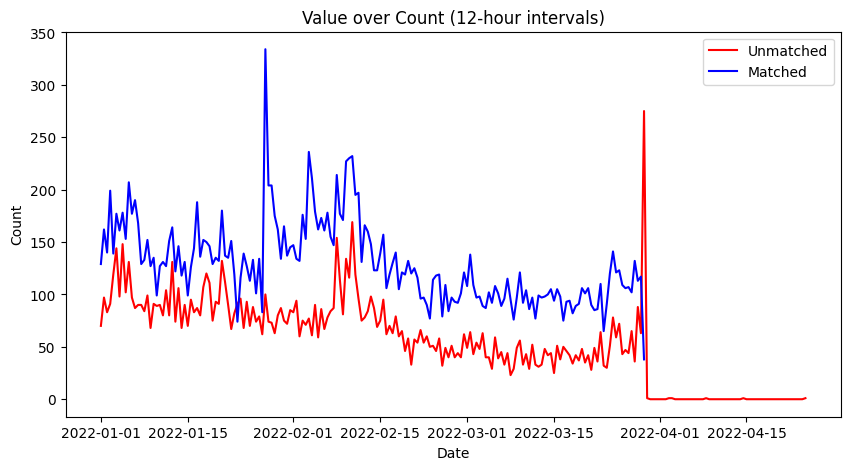

In [72]:
# Resample the data to 12-hour intervals and aggregate using the mean
unmatched_cctxs_withdrawals_resampled = unmatched_cctxs_withdrawals.resample('12h').count()
matched_cctxs_withdrawals_resampled = matched_cctxs_withdrawals.resample('12h').count()

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(unmatched_cctxs_withdrawals_resampled.index, unmatched_cctxs_withdrawals_resampled["value_usd"], label='Unmatched', color='red')
plt.plot(matched_cctxs_withdrawals_resampled.index, matched_cctxs_withdrawals_resampled["value_usd"], label='Matched', color='blue')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Value over Count (12-hour intervals)')
plt.legend()


# Display the plot
plt.show()

In [73]:
unmatched_cctxs_withdrawals.rename(columns={0: 'origin_chain_id', 1: 'origin_timestamp', 2: 'origin_transaction_hash', 3: 'withdrawal_id', 4: 'origin_token', 5: 'dst_token', 6: 'sender', 7: 'beneficiary', 8: 'amount'}, inplace=True)
matched_cctxs_withdrawals.rename(columns={0: 'origin_chain_id', 1: 'origin_timestamp', 2: 'origin_transaction_hash', 3: 'dst_chain_id', 4: 'dst_timestamp', 5: 'dst_transaction_hash', 6: 'withdrawal_id', 7: 'origin_token', 8: 'dst_token', 9: 'sender', 10: 'beneficiary', 11: 'amount'}, inplace=True)

unmatched_cctxs_withdrawals['matched'] = False
matched_cctxs_withdrawals['matched'] = True

all_columns = set(matched_cctxs_withdrawals.columns).union(set(unmatched_cctxs_withdrawals.columns))

for col in all_columns:
    if col not in unmatched_cctxs_withdrawals.columns:
        unmatched_cctxs_withdrawals[col] = None

# Reorder columns to match the order of matched_cctxs_withdrawals
new_unmatched_cctxs_withdrawals = unmatched_cctxs_withdrawals[matched_cctxs_withdrawals.columns]

# Append rows from unmatched_cctxs_withdrawals to matched_cctxs_withdrawals
merged = pd.concat([matched_cctxs_withdrawals, new_unmatched_cctxs_withdrawals], ignore_index=False)

merged.to_csv(f"./{BRIDGE_NAME}/data/matched_and_unmatched_tc_withdrawals.csv")

## Token Withdrawals in S

In [34]:
# Calculate USD value for each transaction

cctxs = pd.read_csv(F"../datalog/{BRIDGE_NAME}/results/SC_ValidERC20TokenWithdrawal.csv", header=None, sep='\t')
cctxs["value_usd"] = None

cctxs["date"] = pd.to_datetime(cctxs.iloc[:, 0], unit='s').dt.strftime('%Y-%m-%d %H:%M')

for index, row in cctxs.iterrows():
    day = datetime.fromtimestamp(row.loc[0]).strftime('%Y-%m-%d')
    try:
        dst_token = MAP_SRC_DST_TOKENS[row.loc[4]]
        tx_volume = calculateTxValueInUSD(MAP_SRC_DST_TOKENS[row.loc[4]], row.loc[6], day)
    except Exception as e:
        tx_volume = np.nan
    
    cctxs.at[index, "value_usd"] = tx_volume

cctxs['date'] = pd.to_datetime(cctxs['date'])
cctxs.set_index('date', inplace=True)

print(len(cctxs))
cctxs.head()

25470


0  \
date                              
2022-01-01 00:05:00  1640995542   
2022-01-01 00:06:00  1640995600   
2022-01-01 00:09:00  1640995775   
2022-01-01 00:15:00  1640996117   
2022-01-01 00:17:00  1640996269   

                                                                     1  \
date                                                                     
2022-01-01 00:05:00  0xf6b7ccd4685a215194c4220afcf8dc32f59ff1d0fee1...   
2022-01-01 00:06:00  0xfd86f961f4eed032e1cb5a9c14bb67cc35d20945a71b...   
2022-01-01 00:09:00  0xe2bce5689f3384feda49e77fbe0f87fc5c8769d2ffc4...   
2022-01-01 00:15:00  0x06c8e4e1c36aee5b3654a137b1e30e1ddd9947d2c436...   
2022-01-01 00:17:00  0xcfa7f7b346b9e0940786fbd616c44a45729d93e9b0fc...   

                           2                                           3  \
date                                                                       
2022-01-01 00:05:00  1025699  0xdd258ae96ebe867bdbe2ae72deb626207dcbdc26   
2022-01-01 00:06:00  1029086  0x27466663437508f761989e64f2c04a187c558f53   
2022-01-01 00:09:00  1029087  0x3a13626b7f02e4fdf5e086d8789581de263497de   
2022-01-01 00:15:00  1029089  0xee1744451a3ad1f42cb40e27f3ca11028feac1a9   
2022-01-01 00:17:00  1029091  0x39d72aa73c2607a6ef9d01fb7a5909152457ab5b   

                                                              4  5  \
date                                                                 
2022-01-01 00:05:00  0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2  1   
2022-01-01 00:06:00  0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2  1   
2022-01-01 00:09:00  0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2  1   
2022-01-01 00:15:00  0xbb0e17ef65f82ab018d8edd776e8dd940327b28b  1   
2022-01-01 00:17:00  0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2  1   

                                          6      value_usd  
date                                                        
2022-01-01 00:05:00       95611650664242460     366.202256  
2022-01-01 00:06:00      641614065873433973    2457.446525  
2022-01-01 00:09:00      296843331547317225    1136.939872  
2022-01-01 00:15:00  3434602115565456438105  331477.137528  
2022-01-01 00:17:00      169486666666666665     649.151012

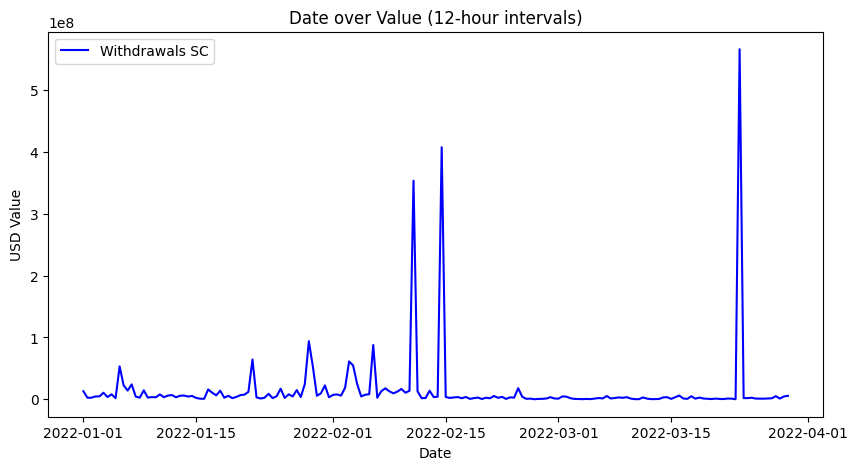

In [ ]:
# Resample the data to 12-hour intervals and aggregate using the mean
withdrawals = cctxs.resample('12h').sum()

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(withdrawals.index, withdrawals["value_usd"], label='Withdrawals SC', color='blue')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('USD Value')
plt.title('Date over Value (12-hour intervals)')
plt.legend()


# Display the plot
plt.show()

In [36]:
# Calculate USD value for each transaction

cctxs = pd.read_csv(F"../datalog/{BRIDGE_NAME}/results/SC_WithdrawalsWithoutMatchWithAdditionalData.csv", header=None, sep='\t')
cctxs["value_usd"] = None

cctxs["date"] = pd.to_datetime(cctxs.iloc[:, 1], unit='s').dt.strftime('%Y-%m-%d %H:%M')

for index, row in cctxs.iterrows():
    day = datetime.fromtimestamp(row.loc[1]).strftime('%Y-%m-%d')
    try:
        dst_token = MAP_SRC_DST_TOKENS[row.loc[4]]
        tx_volume = calculateTxValueInUSD(MAP_SRC_DST_TOKENS[row.loc[4]], row.loc[6], day)
    except Exception as e:
        tx_volume = np.nan
    
    cctxs.at[index, "value_usd"] = tx_volume

print(len(cctxs))
cctxs.head()

732


0           1                                                  2        3  \
0  1  1640999265  0xf0c03bc9f3263dda08eaa4bf881f14b486d9d0aa9794...  1029106   
1  1  1641022072  0xf96af4913701374702eef9c316f073252fb1d0bcc628...  1029212   
2  1  1641023970  0xa0add49557d23658f6bac77edb7a332613457bfd0fa8...   110479   
3  1  1641025805  0xb6ed1e7afbe5f536b8e7b8c2571e49e478bc308e2cdb...   506592   
4  1  1641025883  0x78d02b9bf041f17d61e08ad57bb2700ef84c6e32ba18...   409309   

                                            4  \
0  0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
1  0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
2  0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
3  0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
4  0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   

                                            5                    6  \
0  0x32ced2d723e44dfbdea3362f4901cd95f9b9f191   393782564457443048   
1  0xd32f25dfa932b8064a81b8254e7997caebc85f97  3000000000000000000   
2  0xaabfcd69c5067975d4efaf4b17ef82d92e8fe29d    24478472222222220   
3  0x9b69f334b7ee1afbf381b5b9ef3b3c9b7cb95bf3    50000000000000000   
4  0x9b69f334b7ee1afbf381b5b9ef3b3c9b7cb95bf3    30000000000000000   

      value_usd              date  
0   1508.226902  2022-01-01 01:07  
1  11490.302298  2022-01-01 07:27  
2     93.755015  2022-01-01 07:59  
3    191.505038  2022-01-01 08:30  
4    114.903023  2022-01-01 08:31

In [38]:
# filter based on column 1 > 1648040400 (Wed Mar 23 2022 13:00:00 GMT+0000)
cctxs = cctxs[cctxs[1] > 1648040400]

print(len(cctxs))
cctxs.head()

43


0           1                                                  2  \
689  1  1648042149  0xc28fad5e8d5e0ce6a2eaf67b6687be5d58113e16be59...   
690  1  1648042264  0xed2c72ef1a552ddaec6dd1f5cddf0b59a8f37f82bdda...   
691  1  1648053431  0x08e1246126642645f0f1484553132b941c5ab50b7076...   
692  1  1648065072  0x6c64e3fd25f182d5753058ed7640e052229741442e8c...   
693  1  1648088823  0xa59d355b8821b4d1261fbf3abf1e1e48fc0d6e443b02...   

           3                                           4  \
689  2000000  0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
690  2000001  0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48   
691   607421  0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
692   671728  0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
693   857548  0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   

                                              5                         6  \
689  0x098b716b8aaf21512996dc57eb0615e2383e2f96  173600000000000000000000   
690  0x098b716b8aaf21512996dc57eb0615e2383e2f96            25500000000000   
691  0x492587cc05c82d3d27ce4ca2531facd4d1b4a660         41660990771761946   
692  0xbe52d39a03460556fb40e9a0f7bc1f09167496bb         27925000000000000   
693  0x08a087ebf22693f2f89abdfea83b0f1e60a29741         36362666666666666   

          value_usd              date  
689  539884275.7504  2022-03-23 13:29  
690   25492489.0005  2022-03-23 13:31  
691      129.562868  2022-03-23 16:37  
692       86.844864  2022-03-23 19:51  
693      112.786798  2022-03-24 02:27

In [39]:
cctxs.fillna(0)
total_value = cctxs["value_usd"].sum()
total_addresses = cctxs.iloc[:,5].unique()
print("TOTAL UNIQUE ADDRESSES IDENTIFIED: " + str(len(total_addresses)))
print("TOTAL VALUE (USD): " + str(total_value))
print("TOTAL VALUE (MILLION USD): " + str(total_value / 10**6))

TOTAL UNIQUE ADDRESSES IDENTIFIED: 41
TOTAL VALUE (USD): 565381401.6765534
TOTAL VALUE (MILLION USD): 565.3814016765534


/var/folders/bb/lz0b6jv55n96zj41zzsd4pc80000gn/T/ipykernel_41477/4214297528.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cctxs.fillna(0)


In [40]:
cctxs.rename(columns={0: 'dst_chain_id', 1: 'dst_timestamp', 2: 'dst_transaction_hash', 3: 'withdrawal_id', 4: 'dst_token', 5: 'beneficiary', 6: 'amount'}, inplace=True)
cctxs.to_csv(f"./{BRIDGE_NAME}/data/attacks.csv", index=False)

# Analysis on the data of the selected interval + additional data retrieved on Ethereum

In [ ]:
cctxs = pd.read_csv(F"../datalog/{BRIDGE_NAME}/results/TC_WithdrawalsMatchWithAdditionalData.csv", header=None, sep='\t')
cctxs["value_usd"] = None

for index, row in cctxs.iterrows():
    day = datetime.fromtimestamp(row.loc[1]).strftime('%Y-%m-%d')
    tx_volume = calculateTxValueInUSD(row.loc[7], row.loc[11], day)
    cctxs.at[index, "value_usd"] = tx_volume

print(len(cctxs))
cctxs

187


0           1                                                  2  3  \
0    2020  1641002909  0x904a3fec55d93da800feb42ddd73aadf402b94c9f55b...  1   
1    2020  1641076084  0xb70d56269bfd7708c86d712198967fb647065d507305...  1   
2    2020  1641153557  0x9c765648a0e2d30748028d3878074f8400dab6a868fb...  1   
3    2020  1641173061  0x1f7a28763f77b9d56c214de1c483016cb578c9fcd81d...  1   
4    2020  1641185969  0x2f0ca51fd6a572d0b19ddf38bf0834faf94f2592eb5e...  1   
..    ...         ...                                                ... ..   
182  2020  1648578490  0xdb33188a5ee56c90b8d5cbc206dbcf4e68c01fb527e7...  1   
183  2020  1648584579  0x42f9c311f9a863d737964558087396be1529aa8fcd51...  1   
184  2020  1649428142  0xe36cff97f455bb78b3ac63576e7571c67872e5b3f05d...  1   
185  2020  1649939012  0xb3ff49cc84222857faba4f3a93c7e238a37ad315d0ee...  1   
186  2020  1650803412  0xaf0964bcbf9ffc5282bdff746ee8faf87758afc5b40d...  1   

              4                                                  5        6  \
0    1716779219  0xb5426109eb25454c46c5a8ec470cf225943213b2fa2f...  1029120   
1    1662976932  0x4f409e308d13aa4576e040deec1e2ebefdc819f27b82...  1029522   
2    1656857434  0x242afd1081dc90a745dc1f2c76797fa9ca08246c3c6e...  1029965   
3    1667613419  0x29c23ad17ef93211b98784113a774932db1b9326e309...  1030089   
4    1662350964  0xfd9867bcd8136280d8ce6efe06a2c2ff22d954cab7e8...  1030163   
..          ...                                                ...      ...   
182  1656424005  0x949000d14d4f1b003bf465185463c8f9e95d3c7fc864...  1064485   
183  1658197144  0x65eeead14d12150483cada7a1f9fc4d9311b08755b48...  1064490   
184  1656471913  0x2bdbf6492e50b300b82c067e46d2be6f5350f83ef794...  1064496   
185  1656458912  0x5ed1a12447e26b96799041b7cad406d1c218d10abc7d...  1064497   
186  1695206483  0xe3698bf6393d2d90bf04a3100f10da67a251e05d0b77...  1064498   

                                              7  \
0    0x0b7007c13325c48911f73a2dad5fa5dcbf808adc   
1    0xa8754b9fa15fc18bb59458815510e40a12cd2014   
2    0xa8754b9fa15fc18bb59458815510e40a12cd2014   
3    0xa8754b9fa15fc18bb59458815510e40a12cd2014   
4    0xa8754b9fa15fc18bb59458815510e40a12cd2014   
..                                          ...   
182  0x97a9107c1793bc407d6f527b77e7fff4d812bece   
183  0x97a9107c1793bc407d6f527b77e7fff4d812bece   
184  0xa8754b9fa15fc18bb59458815510e40a12cd2014   
185  0x97a9107c1793bc407d6f527b77e7fff4d812bece   
186  0x0b7007c13325c48911f73a2dad5fa5dcbf808adc   

                                              8  \
0    0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48   
1    0xcc8fa225d80b9c7d42f96e9570156c65d6caaa25   
2    0xcc8fa225d80b9c7d42f96e9570156c65d6caaa25   
3    0xcc8fa225d80b9c7d42f96e9570156c65d6caaa25   
4    0xcc8fa225d80b9c7d42f96e9570156c65d6caaa25   
..                                          ...   
182  0xbb0e17ef65f82ab018d8edd776e8dd940327b28b   
183  0xbb0e17ef65f82ab018d8edd776e8dd940327b28b   
184  0xcc8fa225d80b9c7d42f96e9570156c65d6caaa25   
185  0xbb0e17ef65f82ab018d8edd776e8dd940327b28b   
186  0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48   

                                              9  \
0    0x29bf558f52100b99bb70efb673a3849762a96c7c   
1    0x1d81d2801446645bd9c077aee5a99c8717dfd546   
2    0xffebbdc0fc2d591e5c7040e02c35c84eba419f6b   
3    0x63d709d508dd2931617591309309bb7e17f9b623   
4    0x58157768a7982ad343784aaffca2faa34713be90   
..                                          ...   
182  0xd5db0efb750b20c435be74112376da41e62fda41   
183  0x43af65a9b798d2d20e0dcbf0c516a1f1f2460956   
184  0xd59ca31c0992aaaa5cd64712570c65ddc46d75fa   
185  0x9203deb57b0369f051ba2a351addc5f78e08989e   
186  0x9f9053bd9707995a7be5689965b52a39cff94ca7   

                                             10                     11  \
0    0x0a87ece4e8c11cadabcd9ac850970a322e53b243               33942872   
1    0x56ecf9b910f5e4c613b6ee7e942a9286d52850ec                   2408   
2    0xffebbdc0fc2d591e5c7040e02c35c84eba419f6b  

In [ ]:
addTransactionTimeDifferencesToDataframe(cctxs, 1).head()

NUMBER OF DATAPOINTS: 187
MAX CCTX LATENCY: 79113492
MIN CCTX LATENCY: 6519900
AVG CCTX LATENCY: 22119085.080213904
AVG CCTX LATENCY (MINS): 368651.41800356505
AVG CCTX LATENCY (HOURS): 6144.1903000594175
AVG CCTX LATENCY (DAYS): 256.0079291691424
Standard Deviation of CCTX Latency: 19143168.13111095


0           1                                                  2  3  \
0  2020  1641002909  0x904a3fec55d93da800feb42ddd73aadf402b94c9f55b...  1   
1  2020  1641076084  0xb70d56269bfd7708c86d712198967fb647065d507305...  1   
2  2020  1641153557  0x9c765648a0e2d30748028d3878074f8400dab6a868fb...  1   
3  2020  1641173061  0x1f7a28763f77b9d56c214de1c483016cb578c9fcd81d...  1   
4  2020  1641185969  0x2f0ca51fd6a572d0b19ddf38bf0834faf94f2592eb5e...  1   

            4                                                  5        6  \
0  1716779219  0xb5426109eb25454c46c5a8ec470cf225943213b2fa2f...  1029120   
1  1662976932  0x4f409e308d13aa4576e040deec1e2ebefdc819f27b82...  1029522   
2  1656857434  0x242afd1081dc90a745dc1f2c76797fa9ca08246c3c6e...  1029965   
3  1667613419  0x29c23ad17ef93211b98784113a774932db1b9326e309...  1030089   
4  1662350964  0xfd9867bcd8136280d8ce6efe06a2c2ff22d954cab7e8...  1030163   

                                            7  \
0  0x0b7007c13325c48911f73a2dad5fa5dcbf808adc   
1  0xa8754b9fa15fc18bb59458815510e40a12cd2014   
2  0xa8754b9fa15fc18bb59458815510e40a12cd2014   
3  0xa8754b9fa15fc18bb59458815510e40a12cd2014   
4  0xa8754b9fa15fc18bb59458815510e40a12cd2014   

                                            8  \
0  0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48   
1  0xcc8fa225d80b9c7d42f96e9570156c65d6caaa25   
2  0xcc8fa225d80b9c7d42f96e9570156c65d6caaa25   
3  0xcc8fa225d80b9c7d42f96e9570156c65d6caaa25   
4  0xcc8fa225d80b9c7d42f96e9570156c65d6caaa25   

                                            9  \
0  0x29bf558f52100b99bb70efb673a3849762a96c7c   
1  0x1d81d2801446645bd9c077aee5a99c8717dfd546   
2  0xffebbdc0fc2d591e5c7040e02c35c84eba419f6b   
3  0x63d709d508dd2931617591309309bb7e17f9b623   
4  0x58157768a7982ad343784aaffca2faa34713be90   

                                           10        11   value_usd  \
0  0x0a87ece4e8c11cadabcd9ac850970a322e53b243  33942872   33.934891   
1  0x56ecf9b910f5e4c613b6ee7e942a9286d52850ec      2408   65.813438   
2  0xffebbdc0fc2d591e5c7040e02c35c84eba419f6b      5898  154.872615   
3  0xa08730cacfcf3b85d9d4db50b44557cb03528776     13616  347.559361   
4  0x58157768a7982ad343784aaffca2faa34713be90      2115   53.987078   

   time_difference  day_rounded    datetime_group  
0         75776310            1  2022-01-01 00:00  
1         21900848            1  2022-01-01 00:00  
2         15703877            2  2022-01-02 00:00  
3         26440358            3  2022-01-03 00:00  
4         21164995            3  2022-01-03 00:00

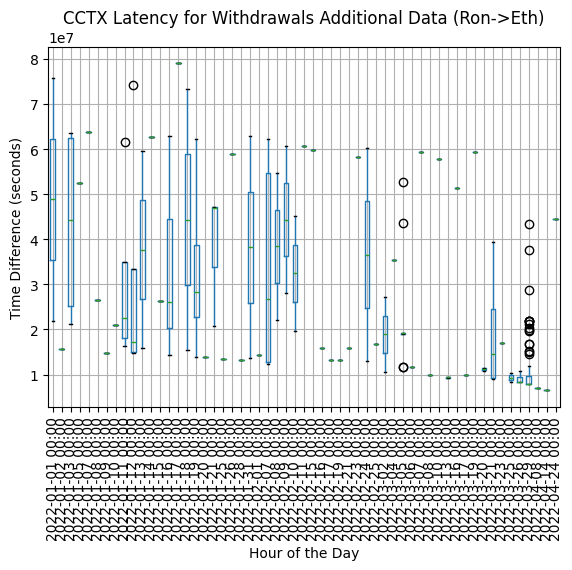

In [ ]:
plotTimeDifferencesBoxplot(cctxs, False, "CCTX Latency for Withdrawals Additional Data (Ron->Eth)")

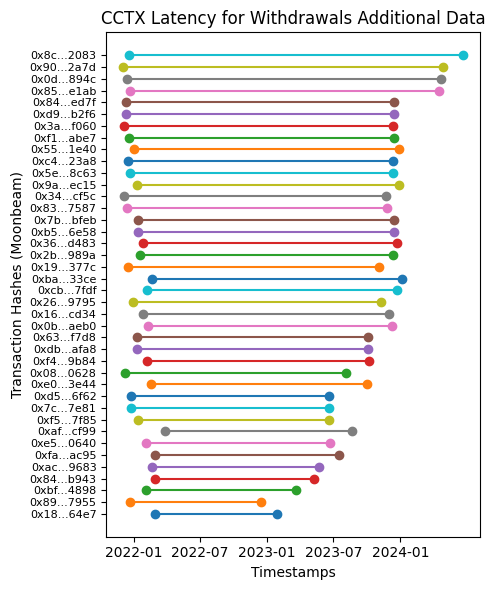

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the CSV has columns: 'address', 'timestamp1', 'timestamp2'
# Convert timestamps to datetime if they are not already
cctxs['timestamp1'] = pd.to_datetime(cctxs.iloc[:,1], unit='s')
cctxs['timestamp2'] = pd.to_datetime(cctxs.iloc[:,4], unit='s')
cctxs.rename(columns={cctxs.columns[2]: 'tx_hash'}, inplace=True)

def shorten_tx_hash(tx_hash, length=4):
    return f"{tx_hash[:length]}...{tx_hash[-length:]}"

cctxs['short_hashes'] = [shorten_tx_hash(tx_hash) for tx_hash in cctxs['tx_hash']]

cctxs = cctxs.sort_values(by='time_difference')

df = cctxs[['short_hashes', 'timestamp1', 'timestamp2', 'time_difference']].tail(40)

# Create the plot
plt.figure(figsize=(5, 6))

# Plot each pair of timestamps for each address
for _, row in df.iterrows():
    plt.plot([row['timestamp1'], row['timestamp2']], [row['short_hashes'], row['short_hashes']], marker='o')

min_date = df['timestamp1'].min()
max_date = df[['timestamp1', 'timestamp2']].max().max()

# Create date range with 2-week intervals
date_range = pd.date_range(start=min_date, end=max_date, freq='6ME')

# Set labels and title
plt.xlabel('Timestamps')
plt.ylabel('Transaction Hashes (Moonbeam)')
plt.title('CCTX Latency for Withdrawals Additional Data')

plt.xticks(ticks=date_range, labels=[date.strftime('%Y-%m') for date in date_range], rotation=0)
plt.yticks(ticks=df['short_hashes'], fontsize=8)
# Show plot
plt.tight_layout()

plt.show()

In [ ]:
# calculate count per year
cctxs['year'] = cctxs['timestamp2'].dt.year

# Group by year and count the number of transactions
count_per_year = cctxs.groupby('year').size()
count_per_year

year
2022    146
2023     22
2024     19
dtype: int64

## Local Blockchain Evaluation

In [ ]:
sc_deposit_facts = pd.read_csv(f'../datalog/{BRIDGE_NAME}/facts/sc_deposit.facts', header=None, sep='\t')
sc_deposit_facts_tx_hashes = sc_deposit_facts[0]
print("Total Deposit Transfers in SC:", len(sc_deposit_facts))

valid_native_deposits = pd.read_csv(f'../datalog/{BRIDGE_NAME}/results/SC_ValidNativeTokenDeposit.csv', header=None, sep='\t')
valid_native_deposits_tx_hashes = valid_native_deposits[1]
print("Total SC Deposit Events:", len(valid_native_deposits_tx_hashes))
add_metrics_to_latex_file(BRIDGE_NAME, "SC_Deposit_Facts", len(valid_native_deposits_tx_hashes))

Total Deposit Transfers in SC: 38462
Total SC Deposit Events: 38462


In [83]:
singe_token_deposits = pd.read_csv(f'../datalog/{BRIDGE_NAME}/results/SingleTokenDeposits.csv', header=None, sep='\t')
singe_token_deposits["value_usd"] = None

print("Total ERC20 Transfers in SC:", len(singe_token_deposits))

singe_token_deposits["date"] = pd.to_datetime(singe_token_deposits.iloc[:, 0], unit='s').dt.strftime('%Y-%m-%d %H:%M')

for index, row in singe_token_deposits.iterrows():
    day = datetime.fromtimestamp(row.loc[0]).strftime('%Y-%m-%d')
    try:
        tx_volume = calculateTxValueInUSD(MAP_SRC_DST_TOKENS[row.loc[4]], row.loc[5], day)
    except Exception as e: # token not mapped in MAP_SRC_DST_TOKENS
        tx_volume = np.nan
    singe_token_deposits.at[index, "value_usd"] = tx_volume

print(len(singe_token_deposits))
singe_token_deposits.head()
add_metrics_to_latex_file(BRIDGE_NAME, "Deposits_Left_S_Facts", len(singe_token_deposits))


Total ERC20 Transfers in SC: 83
83


In [84]:
print(f"Total Value Sent to the Bridge in USD: ${singe_token_deposits['value_usd'].sum():.2f}")
print(f"Total Value Sent to the Bridge in Thousands USD: ${singe_token_deposits['value_usd'].sum() / 10**3:.2f}K")

sorted_singe_token_deposits = singe_token_deposits.sort_values('value_usd', ascending=False)
# populate nan
sorted_singe_token_deposits.fillna(0, inplace=True)
sorted_singe_token_deposits.head(5)

Total Value Sent to the Bridge in USD: $113002.77
Total Value Sent to the Bridge in Thousands USD: $113.00K


/var/folders/bb/lz0b6jv55n96zj41zzsd4pc80000gn/T/ipykernel_68679/2861567987.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sorted_singe_token_deposits.fillna(0, inplace=True)


0  1                                                  2  3  \
43  1645029302  1  0x8f283f90177a29928c9974be3bcf23a9496f674257bd...  0   
28  1644157482  1  0x34a18d7288888a4506e1e3152ed9070816cf1e921ac8...  0   
59  1646266842  1  0xb6aefcbce7912e40b03d8400410e3bdd140123c36c0a...  0   
45  1645118691  1  0xe898f40fa2fe5c8d89df3a2e4f2496bd11daceedce15...  0   
72  1647723943  1  0x5cdf30cb4e940a82b9cb10309d82592030bad0d7c267...  0   

                                             4                       5  \
43  0xbb0e17ef65f82ab018d8edd776e8dd940327b28b  1460015858310000000000   
28  0xbb0e17ef65f82ab018d8edd776e8dd940327b28b    99755000000000000000   
59  0xbb0e17ef65f82ab018d8edd776e8dd940327b28b   125185258000000000000   
45  0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2     1500000000000000000   
72  0xbb0e17ef65f82ab018d8edd776e8dd940327b28b    54245978830000000000   

       value_usd              date  
43  82133.831655  2022-02-16 16:35  
28   6817.229978  2022-02-06 14:24  
59   6219.729012  2022-03-03 00:20  
45   4172.081347  2022-02-17 17:24  
72   2698.550015  2022-03-19 21:05

In [85]:
phishing_txs = singe_token_deposits[singe_token_deposits.iloc[:,3] != 0]
print(f"Txs involving phishing tokens: {len(phishing_txs)}")
non_phishing_txs = singe_token_deposits[singe_token_deposits.iloc[:,3] == 0]
print(f"Just random txs: {len(non_phishing_txs)}")

Txs involving phishing tokens: 3
Just random txs: 80


Token with bad reputation. Phishing attempts: https://etherscan.io/tx/0x7b22e3d03bdb407f42cebf12df1b1f787edbd012c7e07b6e937cbc9651e91056

In [86]:
singe_token_withdrawals = pd.read_csv(f'../datalog/{BRIDGE_NAME}/results/SingleTokenWithdrawal.csv', header=None, sep='\t')
singe_token_withdrawals["value_usd"] = None

singe_token_withdrawals["date"] = pd.to_datetime(singe_token_withdrawals.iloc[:, 0], unit='s').dt.strftime('%Y-%m-%d %H:%M')

for index, row in singe_token_withdrawals.iterrows():
    day = datetime.fromtimestamp(row.loc[0]).strftime('%Y-%m-%d')
    tx_volume = calculateTxValueInUSD(row.loc[4], row.loc[5], day)
    singe_token_withdrawals.at[index, "value_usd"] = tx_volume

singe_token_withdrawals.head()

0  1                                                  2   3  \
0  1648688496  1  0x78b643a338afa5bd56aa2eeccd5c2381a5e5a921986a...  95   

                                            4                    5 value_usd  \
0  0x72c07d9151dce2ea862595487ef7e21cc312e564  1000000000000000000       NaN   

               date  
0  2022-03-31 01:01

In [ ]:
print(f"Total Value Sent to the Bridge in USD: ${singe_token_withdrawals['value_usd'].sum():.2f}")
print(f"Total Value Sent to the Bridge in Thousands USD: ${singe_token_withdrawals['value_usd'].sum() / 10**3:.2f}K")

Total Value Sent to the Bridge in USD: $0.00
Total Value Sent to the Bridge in Thousands USD: $0.00K


THAT TRANSACTION IS A PHISHING ATTEMPT

In [ ]:
# retrieve number of erc20 transfer events to withdraw/deposit on SC

erc20_transfer = pd.read_csv(f'../datalog/{BRIDGE_NAME}/facts/erc20_transfer.facts', header=None, sep='\t')
erc20_transfer_sc = erc20_transfer[erc20_transfer[1] == 1]
print("Total ERC20 Transfers in SC:", len(erc20_transfer_sc))

erc20_deposits = erc20_transfer_sc[erc20_transfer_sc[5] == "0x1a2a1c938ce3ec39b6d47113c7955baa9dd454f2"]
erc20_deposits_2 = erc20_transfer_sc[erc20_transfer_sc[5] == "0x0000000000000000000000000000000000000000"]
erc20_deposits = pd.merge(erc20_deposits, erc20_deposits_2, how='outer')

print("Total ERC20 Transfers for Deposits:", len(erc20_deposits))
add_metrics_to_latex_file(BRIDGE_NAME, "ERC20_Transfer_S_Deposits_Facts", len(erc20_deposits))

token_deps = pd.read_csv(f'../datalog/{BRIDGE_NAME}/facts/sc_token_deposited.facts', header=None, sep='\t')
print("Total Token Deposited Events:", len(token_deps))
add_metrics_to_latex_file(BRIDGE_NAME, "SC_Token_Deposited_Facts", len(token_deps))

spare = set(erc20_deposits[0].to_list()) - set(token_deps[0].to_list())
print("ERC20 Transfers with no Deposit emitted", spare)
print(len(spare)) # according to above, 83 of these are isolated. The remaining are from redundant intermediary contracts (e.g., aggregators) 

spare = set(token_deps[0].to_list()) - set(erc20_deposits[0].to_list())
print("Deposit events emitted with no Transfer", spare)
print(len(spare))

Total ERC20 Transfers in SC: 14259
Total ERC20 Transfers for Deposits: 6245
Total Token Deposited Events: 43989
ERC20 Transfers with no Deposit emitted {'0xa3ed69e0d950e8376ac39ed4d050628e17d3e4cdff21f4f6bce65c9173adfb61', '0x4437d7d9d3a4f97b4449d52b5a8a26f6d8404d4b45ef1d3248b1fd533b339779', '0x68a675542e4116b9be0c937e4d88fce08f5acff0a2c71ab26077e37e722297fd', '0xbbe45375a8a8603b1fb6128177cde830bafe9adb76f82525a9e123b62d880dc2', '0x0abc12e9d29abc88f6975c37058e80088fd7473d94a58b582f4a9ebd71719bcc', '0x1fa5f0990bfd61a74f5b067e70c23c6fadf4de5b942187a93998563f0f49ca5a', '0x99b59bbd8948439252a5c610db7de92fac6d392c7a31adaaf2b7687fd92fcd03', '0x2b52ccbf0443b7ac7ff836d630d2d9b03c8786c0f6f34459b53e3d8b8d0a1e8d', '0xf1b86ba40edc348f08696c62e81513345bedc1b6e930d14a629786a3aca4dba5', '0x7edbc2f6fd5b0c9bcb83e44ae84a028d79da08f211d0c08109e4889774ba6109', '0x0f2652ee1c0551cbed09f5375a8e896aa70c8247b5be780215fd40988bfce52d', '0x7c75eb2be7544f9d787569a01b4191c7358c08bb0b8bb01d354a544f1d5140fa', '0x5683

In [ ]:
erc20_transfer = pd.read_csv(f'../datalog/{BRIDGE_NAME}/facts/erc20_transfer.facts', header=None, sep='\t')
erc20_transfer_SC = erc20_transfer[erc20_transfer[1] == 1]
print("Total ERC20 Transfers in TC:", len(erc20_transfer_SC))

erc20_withdrawals = erc20_transfer_SC[erc20_transfer_SC[4] == "0x1a2a1c938ce3ec39b6d47113c7955baa9dd454f2"]
erc20_withdrawals_2 = erc20_transfer_SC[(erc20_transfer_SC[4] == "0x0000000000000000000000000000000000000000") & (erc20_transfer_SC[4] != "0x1a2a1c938ce3ec39b6d47113c7955baa9dd454f2")]
erc20_withdrawals = pd.merge(erc20_withdrawals, erc20_withdrawals_2, how='outer')

print("Total ERC20 Transfers for Withdrawals:", len(erc20_withdrawals))
add_metrics_to_latex_file(BRIDGE_NAME, "ERC20_Transfer_S_Withdrawals_Facts", len(erc20_withdrawals))

sc_withdrawal_facts = pd.read_csv(f'../datalog/{BRIDGE_NAME}/facts/sc_withdrawal.facts', header=None, sep='\t')
sc_withdrawal_facts_tx_hashes = sc_withdrawal_facts[0]
print("Total withdrawal Transfers in SC:", len(sc_withdrawal_facts))
add_metrics_to_latex_file(BRIDGE_NAME, "SC_Withdrawal_Facts", len(sc_withdrawal_facts))

# append erc20_withdrawals[0].to_list() and sc_withdrawal_facts[0].to_list()
withdrawal_tx_hashes = set(erc20_withdrawals[0].to_list()) | set(sc_withdrawal_facts[0].to_list())


token_withds = pd.read_csv(f'../datalog/{BRIDGE_NAME}/facts/sc_token_withdrew.facts', header=None, sep='\t')
print("Total Token Withdrew Events:", len(token_withds))
add_metrics_to_latex_file(BRIDGE_NAME, "SC_Token_Withdrew_Facts", len(token_withds))

spare = withdrawal_tx_hashes - set(token_withds[0].to_list())
print("ERC20 Transfers with no Withdrawal emitted", spare)
print("Size: ", len(spare))

spare = set(token_withds[0].to_list()) - withdrawal_tx_hashes
print("Withdrawal events emitted with no Transfer", spare)
print("Size: ", len(spare)) # the ones left are sc_withdrawals

Total ERC20 Transfers in TC: 14259
Total ERC20 Transfers for Withdrawals: 6883
Total withdrawal Transfers in SC: 19219
Total Token Withdrew Events: 25470
ERC20 Transfers with no Withdrawal emitted {'0x78b643a338afa5bd56aa2eeccd5c2381a5e5a921986a6ccf7b678958b7d62766'}
Size:  1
Withdrawal events emitted with no Transfer set()
Size:  0


The single tx 0x78b643a338afa5bd56aa2eeccd5c2381a5e5a921986a6ccf7b678958b7d62766 is phishing attempt

In [ ]:
# retrieve number of erc20 transfer events to withdraw/deposit on TC
erc20_transfer = pd.read_csv(f'../datalog/{BRIDGE_NAME}/facts/erc20_transfer.facts', header=None, sep='\t')
erc20_transfer_tc = erc20_transfer[erc20_transfer[1] == 2020]
print("Total ERC20 Transfers in TC:", len(erc20_transfer_tc))

erc20_deposits = erc20_transfer_tc[erc20_transfer_tc[4] == "0x0000000000000000000000000000000000000000"]
erc20_deposits_2 = erc20_transfer_tc[erc20_transfer_tc[4] == "0xe35d62ebe18413d96ca2a2f7cf215bb21a406b4b"]
erc20_deposits = pd.merge(erc20_deposits, erc20_deposits_2, how='outer')

print("Total ERC20 Transfers for Deposits:", len(erc20_deposits))
add_metrics_to_latex_file(BRIDGE_NAME, "ERC20_Transfer_T_Deposits_Facts", len(erc20_deposits))

token_deps = pd.read_csv(f'../datalog/{BRIDGE_NAME}/facts/tc_token_deposited.facts', header=None, sep='\t')
print("Total Token Deposited Events:", len(token_deps))
add_metrics_to_latex_file(BRIDGE_NAME, "TC_Token_Deposited_Facts", len(token_deps))

spare = set(erc20_deposits[0].to_list()) - set(token_deps[0].to_list())
print("ERC20 Transfers with no Deposited emitted", spare)

spare = set(token_deps[0].to_list()) - set(erc20_deposits[0].to_list())
print("Deposited events emitted with no Transfer", spare)

erc20_withdrawals = erc20_transfer_tc[erc20_transfer_tc[5] == "0x0000000000000000000000000000000000000000"]
erc20_withdrawals_2 = erc20_transfer_tc[erc20_transfer_tc[5] == "0xe35d62ebe18413d96ca2a2f7cf215bb21a406b4b"]

erc20_withdrawals = pd.merge(erc20_withdrawals, erc20_withdrawals_2, how='outer')

print("Total ERC20 Transfers for Withdrawals:", len(erc20_withdrawals))
add_metrics_to_latex_file(BRIDGE_NAME, "ERC20_Transfer_T_Withdrawals_Facts", len(erc20_withdrawals)-2)

Total ERC20 Transfers in TC: 79884
Total ERC20 Transfers for Deposits: 44471
Total Token Deposited Events: 43990
ERC20 Transfers with no Deposited emitted set()
Deposited events emitted with no Transfer set()
Total ERC20 Transfers for Withdrawals: 35894


In [ ]:
withdrawals_tc = pd.read_csv(f'../datalog/{BRIDGE_NAME}/facts/tc_token_withdrew.facts', header=None, sep='\t')
withdrawals_tc_tx_hashes = withdrawals_tc[0].to_list()
print("Total tc_token_withdrew in TC:", len(withdrawals_tc_tx_hashes))
add_metrics_to_latex_file(BRIDGE_NAME, "TC_Token_Withdrew_Facts", len(withdrawals_tc_tx_hashes))

missing = erc20_withdrawals[~erc20_withdrawals[0].isin(withdrawals_tc_tx_hashes)]
print("Total ERC20 transfers for Withdrawals in TC that are not valid", len(missing))
print(missing[0].to_list())

Total tc_token_withdrew in TC: 35413
Total ERC20 transfers for Withdrawals in TC that are not valid 0
[]


In [ ]:
isolated_tc_withdrawal_events = pd.read_csv(f'../datalog/{BRIDGE_NAME}/results/SingleEventDeposit.csv', header=None, sep='\t')
isolated_tc_withdrawal_events_tx_hashes = isolated_tc_withdrawal_events[2].to_list()

print("Total isolated token withdrawal events in TC, that did not move any tokens: ", len(isolated_tc_withdrawal_events_tx_hashes))
isolated_tc_withdrawal_events_tx_hashes

Total isolated token withdrawal events in TC, that did not move any tokens:  2


['0x363b7d9da1418414a22c0b2dfc4ff1a59fd5c5a01d4fa852380ee9d95317d774',
 '0x075f4c41f2a72ccbfd7031dcf267ecf078271b075f4ccf398206ea98b5af2579']

In [ ]:
token_deps = pd.read_csv(f'../datalog/{BRIDGE_NAME}/facts/sc_token_deposited.facts', header=None, sep='\t')
print("Total Token Deposited Events:", len(token_deps))

token_deps_2 = pd.read_csv(f'../datalog/{BRIDGE_NAME}/results/SC_ValidERC20TokenDeposit.csv', header=None, sep='\t')
print("Total Token Deposited Events:", len(token_deps_2))

token_deps_3 = pd.read_csv(f'../datalog/{BRIDGE_NAME}/results/SC_ValidNativeTokenDeposit.csv', header=None, sep='\t')
print("Total Token Deposited Events:", len(token_deps_3))

print(len(token_deps_2) + len(token_deps_3))

merged = pd.merge(token_deps_2, token_deps_3, how='outer')

txs = set(merged[1].to_list())
token_deps_txs = set(token_deps[0].to_list())

spare = set(token_deps_txs) - set(txs)
spare

Total Token Deposited Events: 43989
Total Token Deposited Events: 5524
Total Token Deposited Events: 38462
43986


{'0x17153679392088f2af15de128c7ffaf7260be7aded5480f2f999ac011acc48e6',
 '0x646b67d9cb861e1cf3bb9d27f16bcdae057a0e2672bc29f55883f6d46d3e4985',
 '0x8cfad5627d61732041ad09fd77b78235493eee902c6e50295d04441dd50d5184'}

3 unmapped tokens

In [ ]:
token_deps = pd.read_csv(f'../datalog/{BRIDGE_NAME}/facts/tc_token_withdrew.facts', header=None, sep='\t')
print("Total Token Deposited Events:", len(token_deps))

token_deps_2 = pd.read_csv(f'../datalog/{BRIDGE_NAME}/results/TC_ValidERC20TokenWithdrawal.csv', header=None, sep='\t')
print("Total Token Withdrawal Events:", len(token_deps_2))

txs = set(token_deps_2[1].to_list())
token_deps_txs = set(token_deps[0].to_list())

spare = set(token_deps_txs) - set(txs)
print(spare)
spare = set(txs) - set(token_deps_txs)
print(spare)


Total Token Deposited Events: 35413
Total Token Withdrawal Events: 35411
set()
set()
